# <center>Multi armed bandit problems</center>
#### <center> Formulation and mainstream solutions</center>
<img src="./images/MAB_octopus_2.jpg" width="500">
In this notebook are presented a collection of methods commonly used to address the multi-armed bandit problem. Solutions to this problem find lots of useful applications in web advertizing, recommendation systems, shortest path optimization, etc.

The aim of this notebook is to provide an overview of the most famous and easy to use strategies, along with their application on a toy dataset.

Code to run the different methods is available in

In [1]:
ls rl_algos_lib/

ls: rl_algos_lib/: No such file or directory


and can be used by importing modules or classes

In [2]:
import os
import sys

#sys.path.append('{}/Documents/GitHub/decisioning-analysis/Tools/RL_models_library/'.format(os.environ['HOME']))
sys.path.append('{}/Documents/GitHub/RL/'.format(os.environ['HOME']))
from utils.data_gen import generate_fake_bernoulli_bandits

The notebook has the following structure

1. [Introduction](#Introduction)
    * [What is the Multi-Armed Bandit Problem?](#What-is-the-Multi-Armed-Bandit-Problem?)
    * [Multi-Armed Bandit Examples](#Multi-Armed-Bandit-Examples)
    * [Multi-Armed Bandit Solutions](#Multi-Armed-Bandit-Solutions)
    * [Problem setup](#Problem-setup)
    * [Reference metrics](#Reference-metrics)
2. [Multi armed bandit solutions](#Multi-armed-bandit-solutions)
3. [Problem setup](#Problem-setup)
4. [Preparing the data](#Preparing-the-data)
5. [epsilon-greedy](#epsilon-greedy)
6. [Boltzmann exploration](#Boltzmann-exploration)
6. [Upper Confidence Bound](#Upper-Confidence-Bound)
7. [Thompson Sampling](#Thompson-Sampling)
8. [Regret analysis](#Regret-analysis)

## Introduction

### What is the Multi-Armed Bandit Problem?

The term **multi-armed bandit** comes from a hypothetical experiment where a gambler must choose between multiple actions (originally slot machines, the so-called *one-armed bandits*), each with an unknown payout. The goal is to determine the best or most profitable outcome through a series of choices. At the beginning of the experiment, when odds and payouts are unknown, the gambler must determine which machine to pull, in which order and how many times. This is *the multi-armed bandit problem*.

<img src="./images/MAB_pic_3.png" width="600">

### Multi-Armed Bandit Examples

One real-world example of a multi-armed bandit problem is when a news website has to make a decision about which articles to display to a visitor. With no information about the visitor, all click outcomes are unknown. The first question is, which articles will get the most clicks? And in which order should they appear? The website’s goal is to maximize engagement, but they have many pieces of content from which to choose, and they lack data that would help them to pursue a specific strategy.

The news website has a similar problem in choosing which ads to display to its visitors. In this case, they want to maximize advertising revenue, but they may be lacking enough information about the visitor to pursue a specific advertising strategy. Similar to the issue with news articles, they typically have a large number of ads from which to choose. Which ads will drive maximum revenue for their news site? The website needs to make a series of decisions, each with unknown outcome and *payout*.

<img src="./images/MAB_web_2.png" width="600">

These kind of problems can be addressed by using algorithms that *solve* the multi-armed bandit problem. In marketing terms, a multi-armed bandit solution is a *smarter* or more complex version of A/B testing that uses clever algorithms to dynamically allocate traffic to variations that are performing well, while allocating less traffic to variations that are underperforming. In theory, multi-armed bandits should produce faster results since there is no need to wait for a single winning variation.

### Problem setup

The multi-armed bandit scenario is simple to describe, and it boils the **exploration-exploitation** tradeoff down to its purest form.

Suppose you have a set of $K$ actions (arms) labeled by the integers $\left \{ 1, 2, \dots, K \right \}$. We call these actions in the abstract, but in our minds they’re slot machines. 

<img src="./images/MAB_schema_2.png" width="600">

We can then play a game where, in each round, we choose an action (a slot machine to play), and we observe the resulting payout (also called reward). Over many rounds, we might explore the machines by trying some at random. Assuming the machines are not identical, we naturally play machines that seem to pay off well more frequently to try to maximize our total winnings. 

More formally, the problem can be broken down into the following statements: 
* Suppose there are $K$ actions, which, when played, yield either a success or a failure.
* Success can be defined as a reward of value $1$, while failure with a reward of value 0.
* Action $k \in \{1, ..., K\}$ produces a success with probability $0 \le \mu_k \le 1$.
* The success rate vector ${\bf \mu} = (\mu_1, ..., \mu_k)$ is unknown, but its components are stationary, hence it can be learned by performing experiments. 
* The goal of the problem is to maximize the cumulative number of successes (cumulative reward) over a period $T$, where $T$ is much more large than the number of arms $K$.

This is the most general description of the problem we could possibly give. Whichever the formulation, every bandit learning problem will always be characterized by two key components: actions and rewards.

### Reference metrics

To understand the performance of a multi-armed bandit solution, two metrics have to be taken into account

#### Regret

Let us suppose we are given a multi armed bandit problem, for which we know in advance the intrinsic rewards of each arm. This means we can identify the optimal arm to pull. If we keep pulling such arm repeatedly, we will get a maximum expected reward. The latter can be represented as a horizontal line (the red dashed line in the figure below):

 <img src="./images/regret_1.png" width="600">

However, in a real problem statement, we want to define an algorithmic procedure that can rapidly identify the optimal action to choose via trial and error. It has to make repeated trials by pulling different arms till it becomes approximately sure of the arm to pull for maximum average return at a time $t$. The loss it incurs due to time/rounds spent due to the learning is called **regret**.  Regret is very aptly named, as it quantifies exactly how much we regret not picking the optimal arm.

**How do we compute regret?**
Let us suppose we pulled arms for $T$ rounds, for each round $t$ we observe a reward $Y_{I_t,t} \in [0,1]$ associated with the action taken at time $t$, $I_t$. We also define $Y_{best,t}$ as the reward we observe would we always be pulling the best arm. Then the cumulative regret is defined as

\begin{align}
    R_T &= \mathbb{E} \left[\sum_{t=1}^T􏰐(Y_{best,t}−Y_{I_t,t})\right]\\
    &= \sum_{t=1}^T􏰐(\mathbb{E}[Y_{best,t}]−\mathbb{E}[Y_{I_t,t}])\\
    &= \sum_{t=1}^T􏰐(\mu^*−\mathbb{E}[\mu_{I_t}])\\
    &= \sum_{i=1}^n􏰐(\mu^*−\mu_i)\mathbb{E}[T_i]
\end{align}

where $\mu_i$ is the expected reward of action $i$, $\mu^*$ is the best action expected reward and $\mathbb{E}[T_i]$ is the **expected** number of times action $i$ has been chosen over $T$ rounds. When we know in advance each arm reward, the regret of a learning algorithm can be easily estimated by running several experiments and computing the last line of the equation above.

#### Expected reward

If we do not know what is the best arm, we cannot compute the regret. However we can still compare the behavior of different learning algorithms by computing the expected cumulative reward

\begin{equation}
    r_T =  \mathbb{E}\left ( \sum_{t = 1}^TY_{I_t,t} \right),
\end{equation}

or the expected step-averaged reward

\begin{equation}
    r_{avg,T} =  \mathbb{E}\left ( \sum_{t = 1}^T\frac{Y_{I_t,t}}{t} \right),
\end{equation}

where the expectation value should be taken over a certain number of experiments.

### Multi armed bandit solutions

Many different solutions have been developed to tackled the multi-armed bandit problem. In this notebook we will explore the three most commonly used multi-armed bandit solutions:

1. **Epsilon-Greedy**<br>
    This is an algorithm for continuously balancing exploration with exploitation. (In *greedy* experiments, the lever with highest known payout is always pulled except when a random action is taken). A randomly chosen arm is pulled a fraction ε of the time. The other 1-ε of the time, the arm with highest known payout is pulled.
2. **Upper Confidence Bound**<br>
    This strategy is based on the [Optimism in the Face of Uncertainty](https://jeremykun.com/2013/10/28/optimism-in-the-face-of-uncertainty-the-ucb1-algorithm/) principle, and assumes that the unknown mean payoffs of each arm will be as high as possible, based on observable data.
3. **Thompson Sampling (Bayesian)**<br>
    With this randomized probability matching strategy, the number of pulls for a given lever should match its actual probability of being the optimal lever.

## Preparing the data

We start by generating a toy-dataset we can use to test the different learning approaches. To do this we need to create a series of simulated outcomes over which our learning algorithms can be trained. This can be done easily by  associating a success rate to each bandit, and then drawing a corresponding Bernoulli sample for each of them. 

In this case, we will focus on a $K=4$ bandit problem, with success rate vector given by

\begin{equation}
\mathbf{\mu} = (0.7, 0.3, 0.55,0.4)
\end{equation}

This model setup tells us that, on a long term, action $k=1$ is the one we want to take, as it has the highest probability of success.


In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

sys.path.append('{}/Documents/GitHub/RL/'.format(os.environ['HOME']))


In [4]:
from utils.data_gen import generate_fake_bernoulli_bandits

In [5]:
toy_dataset = generate_fake_bernoulli_bandits(0,success_rates=np.array([.7,.3,.55,.4]),number_of_trials=1000)

In [6]:
toy_dataset.head()

,arm_1,arm_2,arm_3,arm_4
0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,1.0
2,1.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,1.0,0.0,0.0,1.0


In [7]:
toy_dataset.mean(axis=0)

arm_1    0.709
arm_2    0.336
arm_3    0.554
arm_4    0.376
dtype: float64

In [8]:
# import matplotlib.pyplot as plt
# import scipy.stats
# import numpy as np


# x_min = 0.0
# x_max = 16.0



# x = np.linspace(x_min, x_max, 100)

# y_1 = scipy.stats.norm.pdf(x,8.0,1.0)
# y_2 = scipy.stats.norm.pdf(x,6.0,2.0)
# y_3 = scipy.stats.norm.pdf(x,5.0,4.0)

# fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(30,10))


# ax1.plot(0,0, label='Next best action=3',linestyle='')
# ax1.plot(x,y_1, color='red')
# ax1.plot(x[60],y_1[60], label='UCB_1',marker='*',markersize=12,color='darkred')
# ax1.fill_between(x,0,y_1,color='red',alpha=.2,)

# ax1.plot(x,y_2, color='green')
# ax1.plot(x[63],y_2[63], label='UCB_2',marker='*',markersize=12,color='darkgreen')
# ax1.fill_between(x,0,y_2,color='green',alpha=.2,)

# ax1.plot(x,y_3, color='blue')

# ax1.plot(x[80],y_3[80], label='UCB_3',marker='*',markersize=12,color='darkblue')
# ax1.fill_between(x,0,y_3,color='blue',alpha=.2,)
# ax1.legend(prop={'size': 16})
# ax1.grid()

# ax1.set_title('Step t',fontsize=20)

# ax1.set_xlabel('Reward',fontsize=20)
# ax1.set_ylabel('Reward Distribution',fontsize=20)

# y_1 = scipy.stats.norm.pdf(x,8.0,1.0)
# y_2 = scipy.stats.norm.pdf(x,6.0,2.0)
# y_3 = scipy.stats.norm.pdf(x,5.0,2.0)

# ax2.plot(0,0, label='Next best action=2',linestyle='')
# ax2.plot(x,y_1, color='red')
# ax2.plot(x[60],y_1[60], label='UCB_1',marker='*',markersize=12,color='darkred')
# ax2.fill_between(x,0,y_1,color='red',alpha=.2,)

# ax2.plot(x,y_2, color='green')
# ax2.plot(x[63],y_2[63], label='UCB_2',marker='*',markersize=12,color='darkgreen')
# ax2.fill_between(x,0,y_2,color='green',alpha=.2,)

# ax2.plot(x,y_3, color='blue')

# ax2.plot(x[56],y_3[56], label='UCB_3',marker='*',markersize=12,color='darkblue')
# ax2.fill_between(x,0,y_3,color='blue',alpha=.2,)
# ax2.legend(prop={'size': 16})
# ax2.grid()

# ax2.set_title('Step t+5',fontsize=20)

# ax2.set_xlabel('Reward',fontsize=20)
# ax2.set_ylabel('Reward Distribution',fontsize=20)

# y_1 = scipy.stats.norm.pdf(x,8.0,1.0)
# y_2 = scipy.stats.norm.pdf(x,6.0,1.5)
# y_3 = scipy.stats.norm.pdf(x,5.0,2.0)

# ax3.plot(0,0, label='Next best action=1',linestyle='')
# ax3.plot(x,y_1, color='red')
# ax3.plot(x[60],y_1[60], label='UCB_1',marker='*',markersize=12,color='darkred')
# ax3.fill_between(x,0,y_1,color='red',alpha=.2,)

# ax3.plot(x,y_2, color='green')
# ax3.plot(x[59],y_2[59], label='UCB_2',marker='*',markersize=12,color='darkgreen')
# ax3.fill_between(x,0,y_2,color='green',alpha=.2,)

# ax3.plot(x,y_3, color='blue')

# ax3.plot(x[56],y_3[56], label='UCB_3',marker='*',markersize=12,color='darkblue')
# ax3.fill_between(x,0,y_3,color='blue',alpha=.2,)
# ax3.legend(prop={'size': 16})
# ax3.grid()

# ax3.set_title('Step t+7',fontsize=20)

# ax3.set_xlabel('Reward',fontsize=20)
# ax3.set_ylabel('Reward Distribution',fontsize=20)

# fig.savefig("normal_distribution.png")
# plt.tight_layout()
# plt.show()

As we can see, the expected reward of each bandit is, within statistical fluctuations, compatible with the original values.

## epsilon-greedy

The epsilon-greedy strategy is one of the easiest procedures adopted to tackle the multi armed bandit problem. It simply implies selecting the (currently) best arm for a given proportion of the trials, and trying a different, randomly chosen arm for the remaining part of the trials.

<img src="./images/e-greedy-scheme.png" width="600">

How do we implement it? Let us first write down some definition 
1. define $n_{i,t}$ to be the number of times arm $i$ has been played up to time $t$.
2. Define $Y_t ∈ [0,1]$ to be the reward we observe at time $t$.
3. Define $I_t ∈ {1...N}$ to be the choice of arm at time $t$. Then the empirical reward estimate of arm $i$ at time $t$ is:

\begin{equation}
\hat{\mu}_{i,t} = \frac{\sum^t_{s=1: I_s=i}Y_s}{n_{i,t}}
\end{equation}

Then the $\epsilon$-greedy policy is

\begin{align}
\text{Input:}\\
&\text{$0<\epsilon<1$, }\text{number of trials $T$, actions (arms) $i=1,...,K$}\\
\end{align}
\begin{align}
\text{for  }i=1&\text{  to  }n\\
\hat{\mu}_{i,0}\leftarrow&\text{prior average reward for action $i$  }\\
\text{for  }t=1&\text{  to  }T\\
r\leftarrow &\mathcal{u}(0,1)\\
\text{if }r&>\epsilon\\
&I_{t}\leftarrow argmax_i(\hat{\mu}_{i,t})\\
\text{else}&\\
&I_{t}\leftarrow\text{randomly chosen action }\\
\hat{\mu}_{i,t}\leftarrow&\text{current average reward for action $i$  }
\end{align}

The role of the $\epsilon$ parameter is to define the **exploration-exploitation** trade off.
Small values of $\epsilon$ implies our algorithm will mostly exploit the (currently known as) best action, while large values will force it to spend more time exploring other options.
The prior probability values assigned at each arm reward can be
1. flat, i.e.
    \begin{equation}
    \mu_{i,0} = \alpha \quad \alpha\in(0,1)
    \end{equation}
2. arm specific, i.e.
    \begin{equation}
    \mu_{i,0} = \alpha_i \quad \alpha_i\in(0,1)
    \end{equation}
    
Using non flat priors could boost the algorithm convergence, provided that their values are close to the real ones. If this is not the case, then one has to tune the value of $\epsilon$ to ensure we can explore enough to identify the best action on the long term.

In the following example, we examine the performance of four different $\epsilon$-greedy strategies, each characterized by a different $\epsilon$ value. In this example we will use flat priors.

In [9]:
from mab.egreedy.egreedy import BernoulliEGreedy

In [10]:
seed = 1

learner_1 = BernoulliEGreedy(toy_dataset.shape[1],toy_dataset.shape[0],.1,np.array([1.,1.,1.,1.]))
learner_1.run_experiment(seed,toy_dataset.values)

learner_2 = BernoulliEGreedy(toy_dataset.shape[1],toy_dataset.shape[0],.3,np.array([1.,1.,1.,1.]))
learner_2.run_experiment(seed,toy_dataset.values)

learner_3 = BernoulliEGreedy(toy_dataset.shape[1],toy_dataset.shape[0],.6,np.array([1.,1.,1.,1.]))
learner_3.run_experiment(seed,toy_dataset.values)

learner_4 = BernoulliEGreedy(toy_dataset.shape[1],toy_dataset.shape[0],.8,np.array([1.,1.,1.,1.]))
learner_4.run_experiment(seed,toy_dataset.values)

### Has been the best option used most of the times?

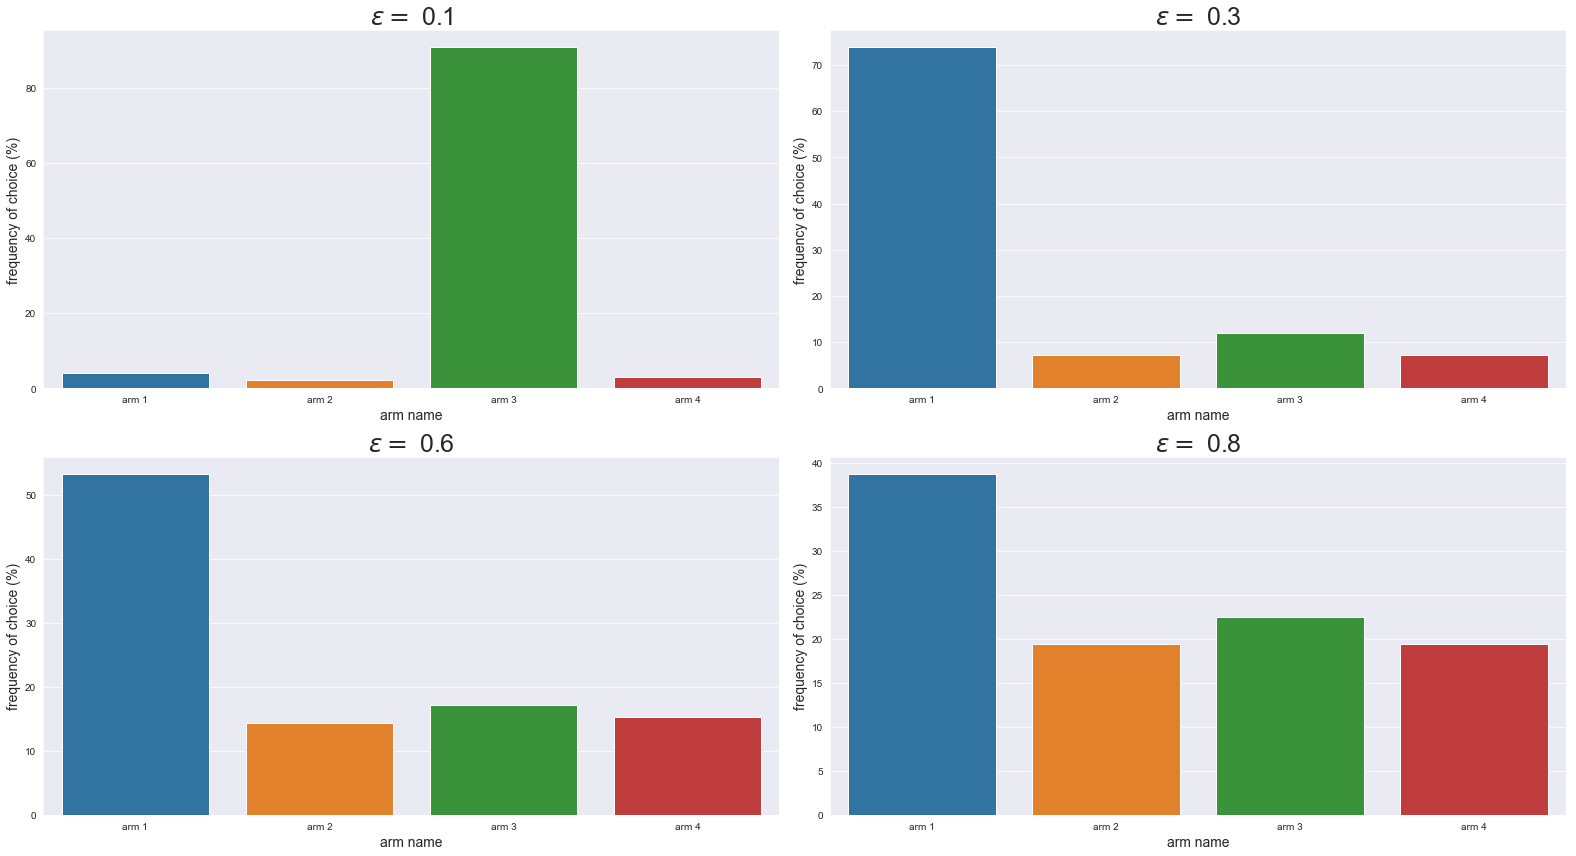

In [11]:
sns.set_style("darkgrid")

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(22,12))

for learner,ax in zip([learner_1,learner_2,learner_3,learner_4],
                      [ax1,ax2,ax3,ax4]):
    data = pd.DataFrame(data=np.array(learner.selected_arms),dtype=int,columns=['selected_arm'])
    data['choice_probability']=1.
    data=data.groupby('selected_arm')[['choice_probability']].count()
    data=data*100/data.sum()
    data['arm'] = ['arm 1','arm 2','arm 3','arm 4']

    sns.barplot(x='arm', y='choice_probability',data=data,ax=ax)
    ax.set_title('$\epsilon=$ {}'.format(learner.epsilon),fontsize=25)
    ax.set_ylabel('frequency of choice (%)',fontsize=14)
    ax.set_xlabel('arm name',fontsize=14)
    
plt.tight_layout()
plt.show()

As we can see, really small values of $\epsilon$ (0.1) cause the algorithm to almost always choose a sub-optimal action: we got stuck into a local minimum!<br>
On the other hand, too large values of $\epsilon$ (0.8) force it to spend too much time exploring other options, and not focussing enough on the most rewarding one.<br>
Intermediate values ($\epsilon=0.3,0.6$) provide a better exploration-vs-exploitation balance, as they allow the algorithm to rapidly identify the best option by doing the right amount of exploration, and then exploit it most of the times.

### What is the time evolution of the reward over time?

In [12]:
total_reward_1 = learner_1.compute_step_cumulative_reward(toy_dataset.values)
total_reward_2 = learner_2.compute_step_cumulative_reward(toy_dataset.values)
total_reward_3 = learner_3.compute_step_cumulative_reward(toy_dataset.values)
total_reward_4 = learner_4.compute_step_cumulative_reward(toy_dataset.values)

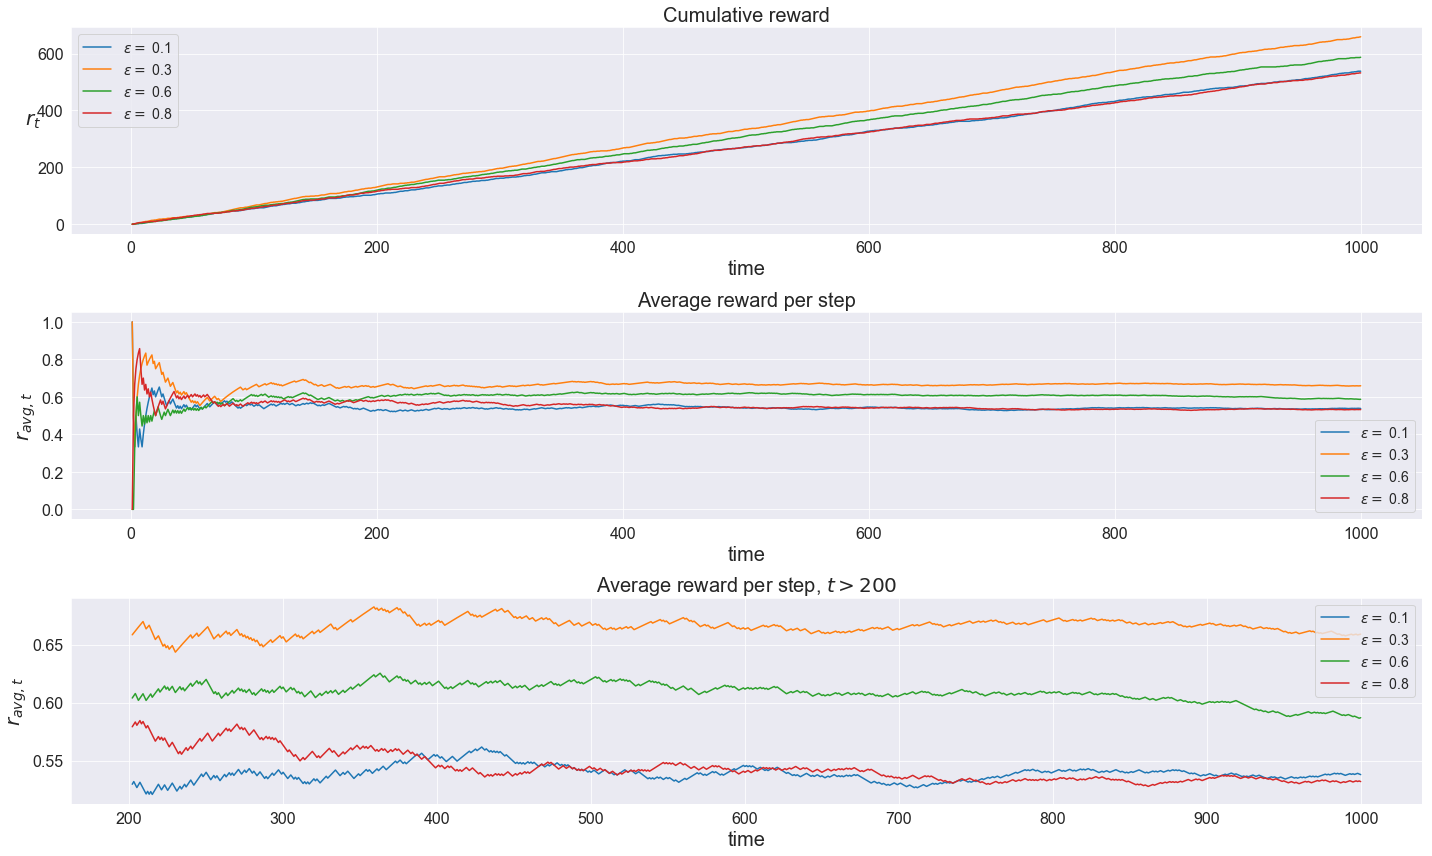

In [13]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(20,12))

xpoints = np.arange(1,learner_1.number_of_trials+1)
for learner,total_reward in  zip([learner_1,learner_2,learner_3,learner_4],
                                 [total_reward_1,total_reward_2,total_reward_3,total_reward_4]):
    ax1.plot(xpoints,total_reward,label='$\epsilon=$ {}'.format(learner.epsilon))
ax1.set_xlabel('time',fontsize=20)
ax1.set_ylabel('$r_t$',fontsize=20,rotation='horizontal')
ax1.set_title('Cumulative reward',fontsize=20)
ax1.legend(prop={'size': 14})
ax1.tick_params(axis='both', which='major', labelsize=16)

for learner,total_reward in  zip([learner_1,learner_2,learner_3,learner_4],
                                 [total_reward_1,total_reward_2,total_reward_3,total_reward_4]):
    ax2.plot(xpoints,total_reward/xpoints,label='$\epsilon=$ {}'.format(learner.epsilon))
ax2.set_xlabel('time',fontsize=20)
ax2.set_ylabel('$r_{avg,t}$',fontsize=20)
ax2.set_title('Average reward per step',fontsize=20)
ax2.legend(prop={'size': 14})
ax2.tick_params(axis='both', which='major', labelsize=16)

for learner,total_reward in  zip([learner_1,learner_2,learner_3,learner_4],
                                 [total_reward_1,total_reward_2,total_reward_3,total_reward_4]):
    ax3.plot(xpoints[201:],total_reward[201:]/xpoints[201:],label='$\epsilon=$ {}'.format(learner.epsilon))
ax3.set_xlabel('time',fontsize=20)
ax3.set_ylabel('$r_{avg,t}$',fontsize=20)
ax3.set_title('Average reward per step, $t > 200$',fontsize=20)
ax3.legend(prop={'size': 14})
ax3.tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()
plt.show()

As we can see from the plot, the $\epsilon=0.3$ strategy seems to be best one, as its cumulative reward over time is the largest.

## Boltzmann exploration

The $\epsilon$-greedy strategy is characterized by two big flaws

1. It cannot automatically tune the exploration-exploitation trade off as the number of trials increases. This means that, once the optimal action has been clearly identified, the algorithm will continue to spend some time (how much it depends on the value of $\epsilon$) by doing random exploration.
2. During the exploration phase, the algorithm explores options completely at random without any concern about their merits. Why is this a problem? Let us look at the following example
    * **Scenario A**: we have two arms, one providing reward 10% of the time, the other 13% of the time.
    * **Scenario B**: the two arms provide reward 10% and 99% of the time
    
   In both of these scenarios, the probability that the $\epsilon$-greedy algorithm explores the worse arm is exactly the same (i.e. $\epsilon$/2), and this is a problem for several reasons:
   * If the difference in rewards between two arms is small, then we need to explore a lot more often (definitely more than $\epsilon$ times) to correctly determine which of the two options is the best one
   * If the difference is large, we need to explore a lot less (definitely less than $\epsilon$ times) to correctly estimate the better of two options. For sure we do not want to lose a lot of reward by exploring an unambiguosly inferior option in this case.

To solve these two problems we need to define an algorithmic procedure that:
1. is capable of intelligently reducing the exploration in favour of the exploitation as the number of trials increases.
2. cares about the known differences between the estimated values of the arms when it has to decide which arm to explore.

Different policies have been developed to properly satisfy these two requisites: among these, the **Boltzmann exploration policy** is the simplest one. Its algorithmic form is the following

\begin{align}
\text{Input:}\\
&\text{$k_b\in R$, }\text{number of trials $T$, actions (arms) $i=1,...,K$}\\
\end{align}
\begin{align}
\text{for  }i=1&\text{  to  }K\\
\hat{\mu}_{i,0}\leftarrow&\text{  prior average reward for action $i$  }\\
\text{for  }t=1&\text{  to  }T\\
\tau \leftarrow& k_b t\\
\hat{\pi}_{i}\leftarrow& \frac{e^{\hat{\mu}_{i}/\tau}}{\sum^n_{i=1}e^{\hat{\mu}_{i}/\tau}}\\
\text{choose}&\text{ action $i$ with probability $\hat{\pi}_{i}$}\\
\hat{\mu}_{i,t}\leftarrow&\text{current average reward for action $i$  }
\end{align}

**How does this policy work?** 

Instead of choosing an action randomly, we assign it a *probability of being chosen*[<sup>1</sup>](#fn1)

\begin{equation}
\hat{\pi}_{i} = \frac{e^{\hat{\mu}_{i}/\tau}}{\sum^n_{i=1}e^{\hat{\mu}_{i}/\tau}}
\end{equation}

such probability depends on two parameters
1. the current expected reward $\hat{\mu}_{i}$ of arm $i$. The higher the reward, the higher is the probability for action $i$ to be chosen.
2. the *normalized temperature value* [<sup>2</sup>](#fn2)
    \begin{equation}
    \frac{1}{\tau}=k_b t
    \end{equation}
   This parameter allows the policy to smoothly transition from the exploration phase to the exploitation one. 
   
<img src="./images/softmax.png" width="1000">
   
   At the beginning of the learning phase (small times) the temperature is high, and this will trigger high exploration. If we look at the picture above, we can see that for small times each arm is assigned almost the same probability (in this case $1/4$). In this phase the algorithm is exploring arms randomly, on the same way as the $\epsilon$-greedy policy. As time moves forward, the temperature decreases and the probability of the arm with the highest reward becomes dominant. The algorithm will start picking up the best arm most of the times, disregarding the other options. This procedure of smoothly reducing the exploration by lowering the value of the temperature is called **annealing**[<sup>3</sup>](#fn3).

<br>
<br>






<span id="fn1"> **1** The transformation used to define $\hat{\pi}_{i}$ is the so-called [softmax function](https://en.wikipedia.org/wiki/Softmax_function): it allows us to relate rewards (which in general are not bounded between $0$ and $1$) to probabilities.</span>

<span id="fn2"> **2** This is a term inherited from the universe of statistical physics, where $\tau$ is used to define the temperature of a system of particles.</span> 

<span id="fn3"> **3** The name annealing is based on a metaphor about blacksmitting. It is a heat treatment that alters the physical and sometimes chemical properties of a material to increase its ductility and reduce its hardness, making it more workable. It involves heating a material above its recrystallization temperature, maintaining a suitable temperature for a suitable amount of time, and then allow slow cooling.</span> 

Let us have a look the Boltzmann exploration policy in action

In [14]:
from mab.boltzmann.softmax import BernoulliSoftmaxAnnealing

In [17]:
seed = 1

learner_1 = BernoulliSoftmaxAnnealing(toy_dataset.shape[1],toy_dataset.shape[0],.001,np.array([1.,1.,1.,1.]))
learner_1.run_experiment(seed,toy_dataset.values)

learner_2 = BernoulliSoftmaxAnnealing(toy_dataset.shape[1],toy_dataset.shape[0],.01,np.array([1.,1.,1.,1.]))
learner_2.run_experiment(seed,toy_dataset.values)

learner_3 = BernoulliSoftmaxAnnealing(toy_dataset.shape[1],toy_dataset.shape[0],1.,np.array([1.,1.,1.,1.]))
learner_3.run_experiment(seed,toy_dataset.values)

learner_4 = BernoulliSoftmaxAnnealing(toy_dataset.shape[1],toy_dataset.shape[0],10.,np.array([1.,1.,1.,1.]))
learner_4.run_experiment(seed,toy_dataset.values)

### Has been the best option used most of the times?

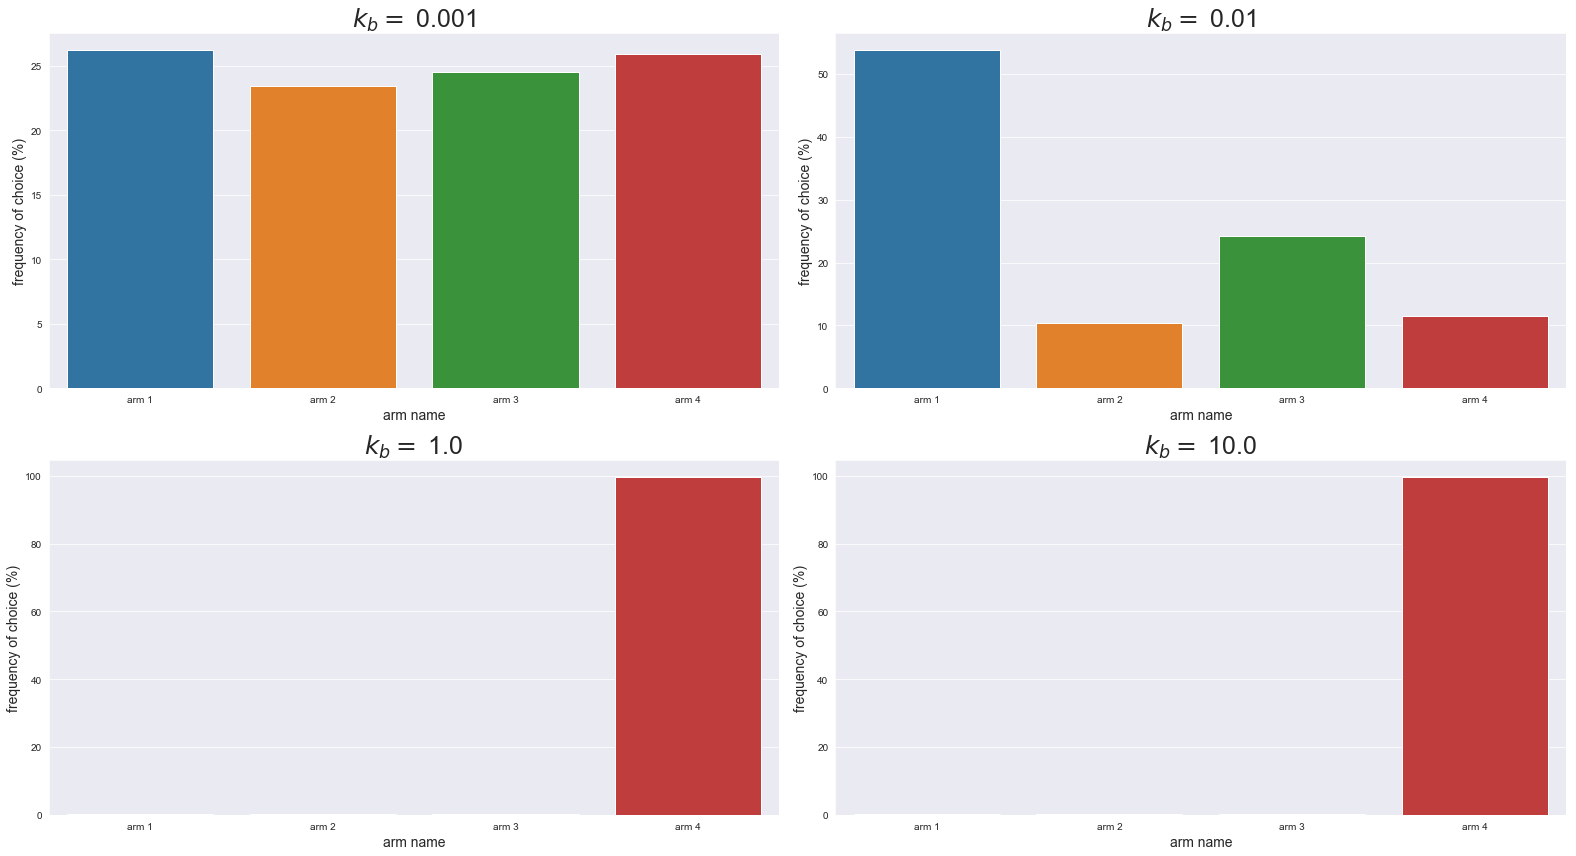

In [18]:
sns.set_style("darkgrid")

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(22,12))

for learner,ax in zip([learner_1,learner_2,learner_3,learner_4],
                      [ax1,ax2,ax3,ax4]):
    data = pd.DataFrame(data=np.array(learner.selected_arms),dtype=int,columns=['selected_arm'])
    data['choice_probability']=1.
    data=data.groupby('selected_arm')[['choice_probability']].count()
    data=data*100/data.sum()
    data['arm'] = ['arm 1','arm 2','arm 3','arm 4']

    sns.barplot(x='arm', y='choice_probability',data=data,ax=ax)
    ax.set_title('$k_b=$ {}'.format(learner.kappa),fontsize=25)
    ax.set_ylabel('frequency of choice (%)',fontsize=14)
    ax.set_xlabel('arm name',fontsize=14)
    
plt.tight_layout()
plt.show()

From the plots above we can see how important is to assign a proper value of $k_b$ to reach convergence.
Small values of $k_b$ make the cooling procedure really slow, which means the algorithm will spend most of the trials by exploring all the available options.
On the other hand, large values of $k_b$ bring the system to cool down too rapidly, risking to gettin trapped into a local minimum (see the $k_b=1$ and $k_b=10$ case).
$k_b$ is a hyperparameter of the *Boltzmann exploration policy*: depending on the problem at hand, it has to be tuned accordingly.

### What is the time evolution of the reward over time?

In [21]:
total_reward_1 = learner_1.compute_step_cumulative_reward(toy_dataset.values)
total_reward_2 = learner_2.compute_step_cumulative_reward(toy_dataset.values)
total_reward_3 = learner_3.compute_step_cumulative_reward(toy_dataset.values)
total_reward_4 = learner_4.compute_step_cumulative_reward(toy_dataset.values)

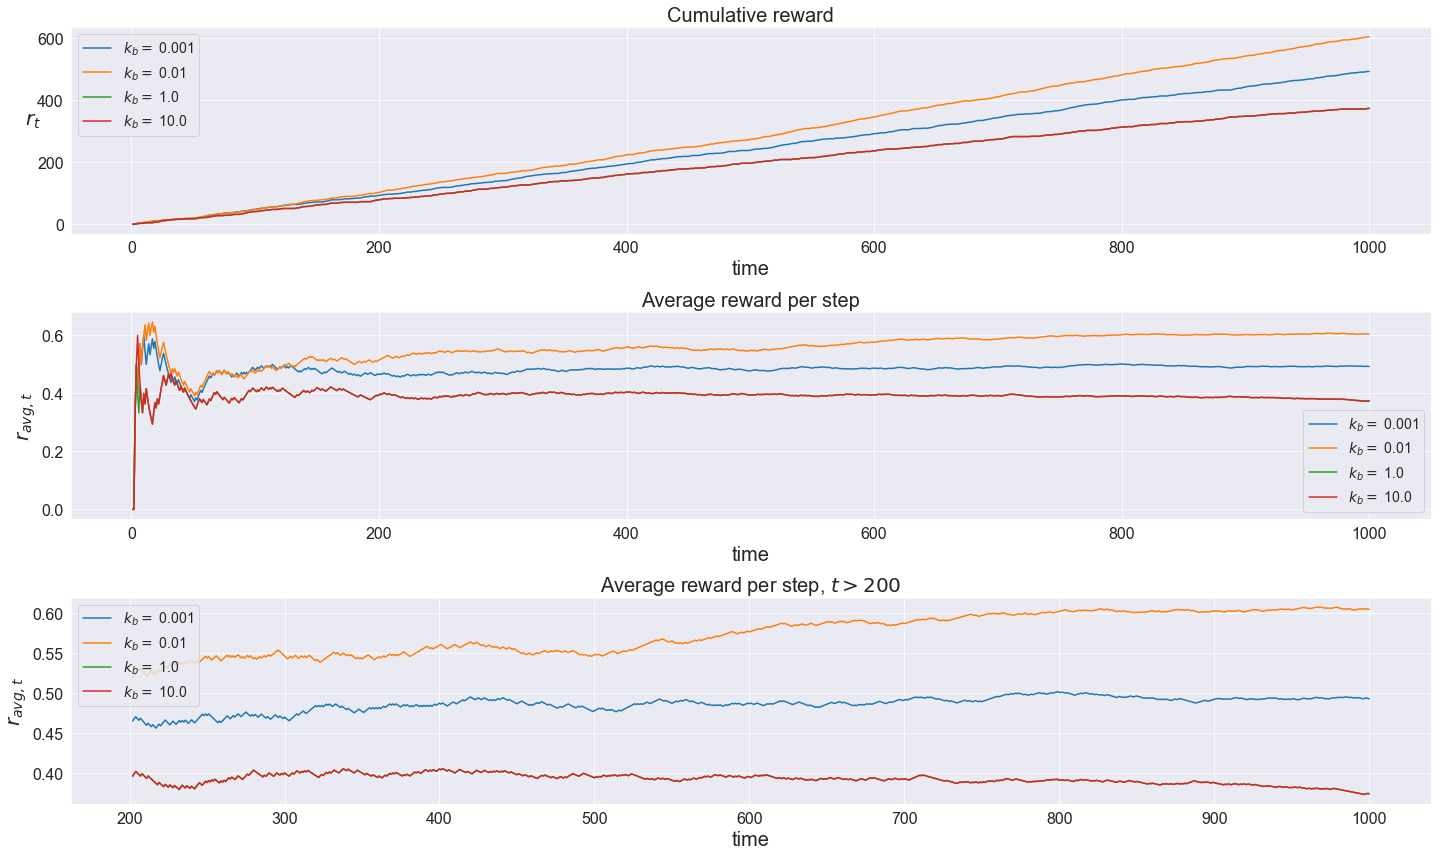

In [22]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(20,12))

xpoints = np.arange(1,learner_1.number_of_trials+1)
for learner,total_reward in  zip([learner_1,learner_2,learner_3,learner_4],
                                 [total_reward_1,total_reward_2,total_reward_3,total_reward_4]):
    ax1.plot(xpoints,total_reward,label='$k_b=$ {}'.format(learner.kappa))
ax1.set_xlabel('time',fontsize=20)
ax1.set_ylabel('$r_t$',fontsize=20,rotation='horizontal')
ax1.set_title('Cumulative reward',fontsize=20)
ax1.legend(prop={'size': 14})
ax1.tick_params(axis='both', which='major', labelsize=16)

for learner,total_reward in  zip([learner_1,learner_2,learner_3,learner_4],
                                 [total_reward_1,total_reward_2,total_reward_3,total_reward_4]):
    ax2.plot(xpoints,total_reward/xpoints,label='$k_b=$ {}'.format(learner.kappa))
ax2.set_xlabel('time',fontsize=20)
ax2.set_ylabel('$r_{avg,t}$',fontsize=20)
ax2.set_title('Average reward per step',fontsize=20)
ax2.legend(prop={'size': 14})
ax2.tick_params(axis='both', which='major', labelsize=16)

for learner,total_reward in  zip([learner_1,learner_2,learner_3,learner_4],
                                 [total_reward_1,total_reward_2,total_reward_3,total_reward_4]):
    ax3.plot(xpoints[201:],total_reward[201:]/xpoints[201:],label='$k_b=$ {}'.format(learner.kappa))
ax3.set_xlabel('time',fontsize=20)
ax3.set_ylabel('$r_{avg,t}$',fontsize=20)
ax3.set_title('Average reward per step, $t > 200$',fontsize=20)
ax3.legend(prop={'size': 14})
ax3.tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()
plt.show()

## Upper Confidence Bound

So far, the algorithms presented have one systematic weakness: they do not keep track of how much they know about any of the arms available to them. They pay attention only to how much reward they got from each arm. This is a problem because they tend to underexplore options whose initial experiences were not rewarding, even though they don't have enough data to be confident about those arms. What we would like to have is an algorithm that pays attention to not only *what it knows*, but also to *how much it knows*.

**Upper Confidfence Bound** and **Thompson Sampling** are the two policies we are looking for. In this section we will focus on the former.

### UCB at high level
Upper Confidence Bound (UCB) is one of the most widely used solutions for multi-armed bandit problems. This algorithm is based on the principle of *optimism in the face of uncertainty*, but what does it mean?<br>

*Despite our lack of knowledge in what actions are best we will construct an optimistic guess as to how good the expected payoff of each action is, and pick the action with the highest guess. If our guess is wrong, then our optimistic guess will quickly decrease and we’ll be compelled to switch to a different action.* 

Still not clear? Let us make a simple example.

Suppose we can choose between three different actions (or arms) $K={1,2,3}$. To each action corresponds an *expected reward*, with a given level of uncertainty.

<img src="./images/UCB_example.png" width="2000">

The distributions above show that action $K=1$ provides the highest possible reward, while action $K=3$ comes will bring the lowest one. However it also has the largest uncertainty, so it is hard for us to assess its real value with confidence. Indeed, due to the large uncertainty, action $3$ reward could take even larger values than the other actions, and we would be tempted to choose it. So how do we choose the right action?<br>
What we can do is using the value of each uncertainty to build an optimistic guess (an *upper confidence bound*) of the expected rewards

\begin{equation}
UCB_i = \hat{\mu}_i + \delta_i,
\end{equation}

where $\hat{\mu}_i$ is the estimated reward of action $i$ at a given time, while $\delta_i$ depends somehow on the uncertainty around the real reward $\mu_i$. The **UCB policy** says we should play the action with the highest upper bound, observe the reward, and modify the upper bound value as the uncertainty around the real reward has been reduced. The intuitive reason on why does this work is that when acting optimistically, one of two things happen:

* optimism is justified and we get a positive reward which is the objective ultimately
* the optimism was not justified. In this case, we play an arm that we believed might give a large reward when in fact it does not. If this happens sufficiently often, then we will learn what is the true payoff of this action and not choose it in the future.

If we look at the example above, we can see how acting optimistically can drive us to choose the right action on the long term

1. **Step t**. Among all the possible actions, $K=3$ is the one with the largest UCB, therefore we choose it.
2. **Step t+5**. After $5$ iterations, the uncertainty surrounding action $3$ is reduced, and we understand that this action is not paying off, therefore we discard it. Now it seems that action $K=2$ could provide the highest possible reward, hence we decide to try it.
3. **Step t+7**. After having played action $2$ twice, we find out that the action with the largest UCB is $K=1$, therefore we play it.

### UCB policy algorithm

The mechanics of the upper confidence bound (UCB) algorithm is simple. At each round, we simply pull the arm that has the highest empirical reward estimate up to that point plus some term that’s inversely proportional to the number of times the arm has been played. More formally

1. define $n_{i,t}$ to be the number of times arm $i$ has been played up to time $t$
2. define $Y_t ∈ [0,1]$ to be the reward we observe at time $t$.
3. define $I_t ∈ {1...N}$ to be the choice of arm at time $t$.

Then the empirical reward estimate of arm i at time $t$ is:

\begin{equation}
\hat{\mu}_{i,t} = \frac{\sum^t_{s=1: I_s=i}Y_s}{n_{i,t}}
\end{equation}

UCB then assigns the following value to each arm $i$ at each time $t$:

\begin{equation}
UCB_{i,t} = \hat{\mu}_{i,t}+\delta_{i,t} = \hat{\mu}_{i,t}+\sqrt{\frac{2\log{t}}{n_{i,t}}}
\end{equation}

Based on the definion above, the UCB policy algorithm is

<img src="./images/UCB_algo.png" width="600">

We will not go into the mathematical proof of convergence of the UCB policy. However, it is important to understand the expression that corresponds to our selected action. 
Each time an arm $i$ is selected, the uncertainty around its reward is presumably reduced: $n_{i,t}$ increments, and, as it appears in the denominator, the uncertainty term decreases.

\begin{equation}
n_{i,t}  \uparrow \quad \sqrt{\frac{2\log{t}}{n_{i,t}}} \downarrow
\end{equation}

On the other hand, each time an action other than $i$ is selected, $t$ increases, but $n_{i,t}$ does not; because $t$ appears in the numerator, the uncertainty estimate increases.

\begin{equation}
n_{i,t}  \uparrow \quad \sqrt{\frac{2\log{t}}{n_{i,t}}} \uparrow
\end{equation}

The use of the natural logarithm means that the increases get smaller over time; all actions will eventually be selected, but actions with lower value estimates, or that have already been selected frequently, will be selected with decreasing frequency over time.
This will ultimately lead to the optimal action being selected repeatedly in the end.

As we can see, the first $N$ rounds of the algorithm are used to compute the starting values of the expected reward for each arm.
However this procedure can be avoided if we can assign some meaningful value to $\mu_{i,0}$ based on our prior knowledge.

In the following example, we examine the performance of the UCB policy.

In [23]:
from mab.ucb.ubc1 import BernoulliUCB

learner = BernoulliUCB(toy_dataset.shape[1],toy_dataset.shape[0])
learner.run_experiment(toy_dataset.values)

In [24]:
learner.number_of_selections

array([705.,  57., 181.,  57.])

We can now analyze the behavior of this algorithm.

### Has been the best option used most of the times?

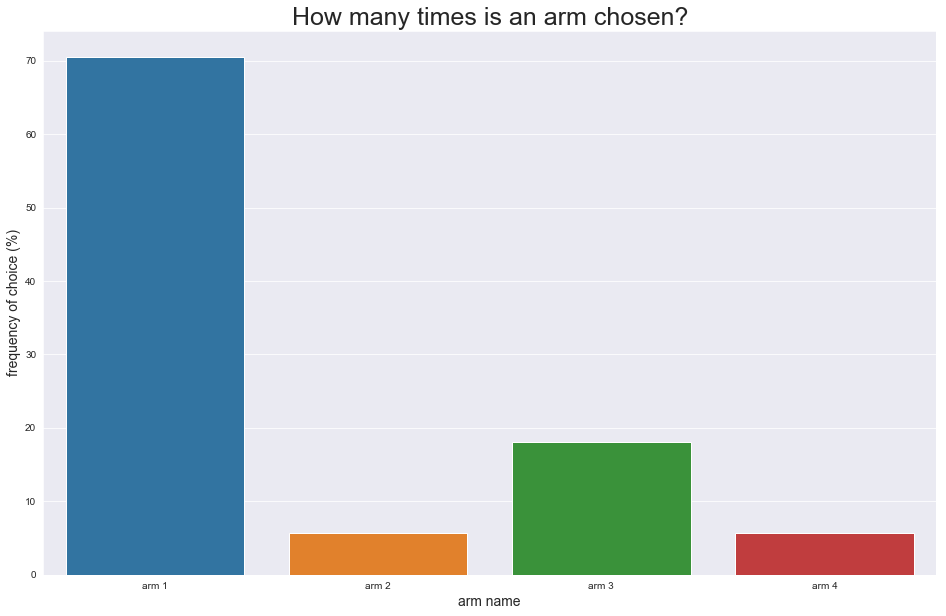

In [25]:
sns.set_style("darkgrid")

data = pd.DataFrame(data=np.array(learner.selected_arms),dtype=int,columns=['selected_arm'])
data['choice_probability']=1.
data=data.groupby('selected_arm')[['choice_probability']].count()
data=data*100/data.sum()
data['arm'] = ['arm 1','arm 2','arm 3','arm 4']

plt.figure(figsize=(16,10))
sns.barplot(x='arm', y='choice_probability',data=data)
plt.title('How many times is an arm chosen?',fontsize=25)
plt.ylabel('frequency of choice (%)',fontsize=14)
plt.xlabel('arm name',fontsize=14)
plt.show()

As expected, the best arm is the one chosen most over the entire history, followed by arm $3$, $4$ and then $2$

### What is the evolution of the estimated success rate of each arm?

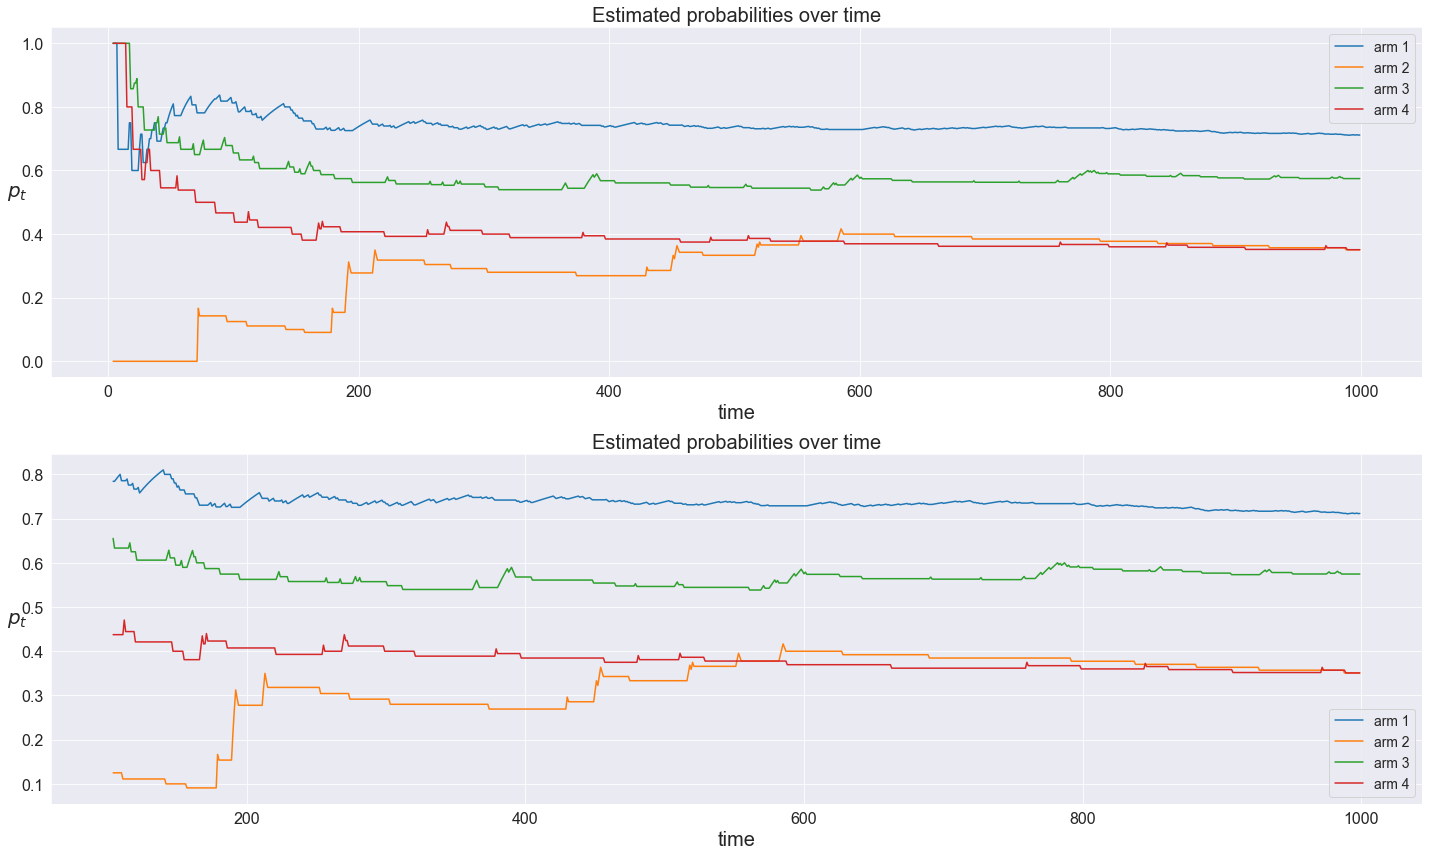

In [26]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(20,12))

xpoints = np.arange(learner.number_of_arms,learner.number_of_trials)

ax1.plot(xpoints,learner.arms_average_rewards[:,0],label='arm 1')
ax1.plot(xpoints,learner.arms_average_rewards[:,1],label='arm 2')
ax1.plot(xpoints,learner.arms_average_rewards[:,2],label='arm 3')
ax1.plot(xpoints,learner.arms_average_rewards[:,3],label='arm 4')
ax1.set_xlabel('time',fontsize=20)
ax1.set_ylabel('$p_{t}$',fontsize=20,rotation='horizontal')
ax1.set_title('Estimated probabilities over time',fontsize=20)
ax1.legend(prop={'size': 14})
ax1.tick_params(axis='both', which='major', labelsize=16)

ax2.plot(xpoints[100:],learner.arms_average_rewards[100:,0],label='arm 1')
ax2.plot(xpoints[100:],learner.arms_average_rewards[100:,1],label='arm 2')
ax2.plot(xpoints[100:],learner.arms_average_rewards[100:,2],label='arm 3')
ax2.plot(xpoints[100:],learner.arms_average_rewards[100:,3],label='arm 4')
ax2.set_xlabel('time',fontsize=20)
ax2.set_ylabel('$p_{t}$',fontsize=20,rotation='horizontal')
ax2.set_title('Estimated probabilities over time',fontsize=20)
ax2.legend(prop={'size': 14})
ax2.tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()
plt.show()

### What is the time evolution of the reward over time?

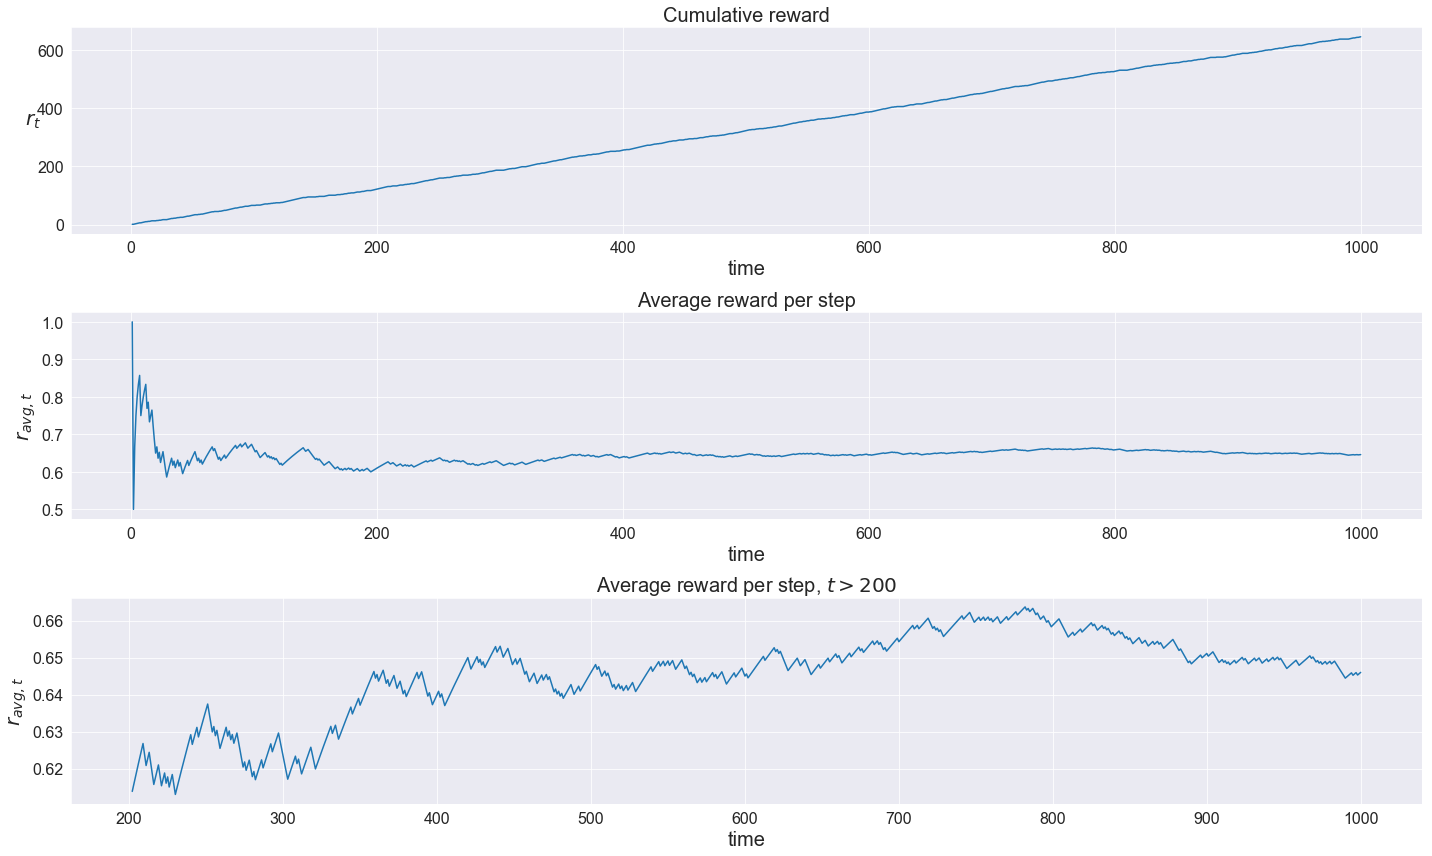

In [27]:
total_reward = learner.compute_step_cumulative_reward(toy_dataset.values)

fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(20,12))

xpoints = np.arange(1,learner.number_of_trials+1)
ax1.plot(xpoints,total_reward)
ax1.set_xlabel('time',fontsize=20)
ax1.set_ylabel('$r_t$',fontsize=20,rotation='horizontal')
ax1.set_title('Cumulative reward',fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=16)

ax2.plot(xpoints,total_reward/xpoints)
ax2.set_xlabel('time',fontsize=20)
ax2.set_ylabel('$r_{avg,t}$',fontsize=20)
ax2.set_title('Average reward per step',fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=16)

ax3.plot(xpoints[201:],total_reward[201:]/xpoints[201:])
ax3.set_xlabel('time',fontsize=20)
ax3.set_ylabel('$r_{avg,t}$',fontsize=20)
ax3.set_title('Average reward per step, $t > 200$',fontsize=20)
ax3.tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()
plt.show()

### Can we inspect the history of the UCB1 decision process?

Yes we can, just use the commands below. Change the number of intervals to get more or less granular time snapshots

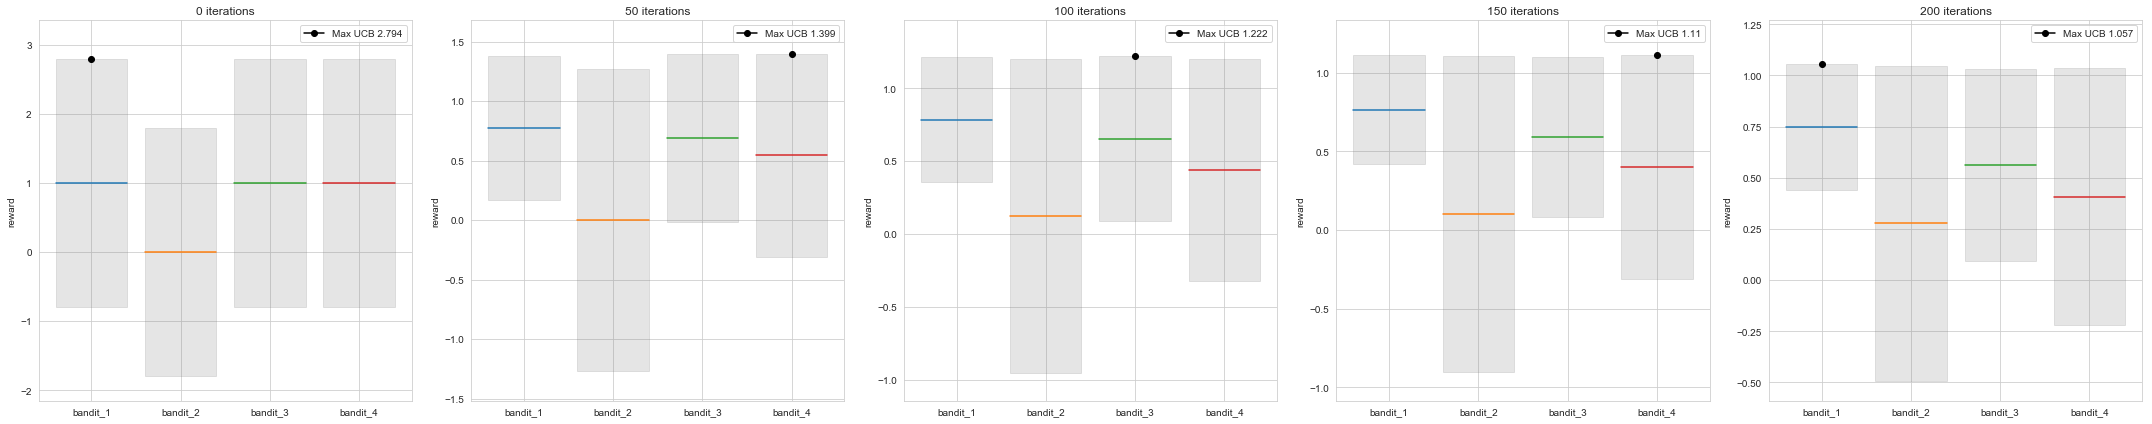

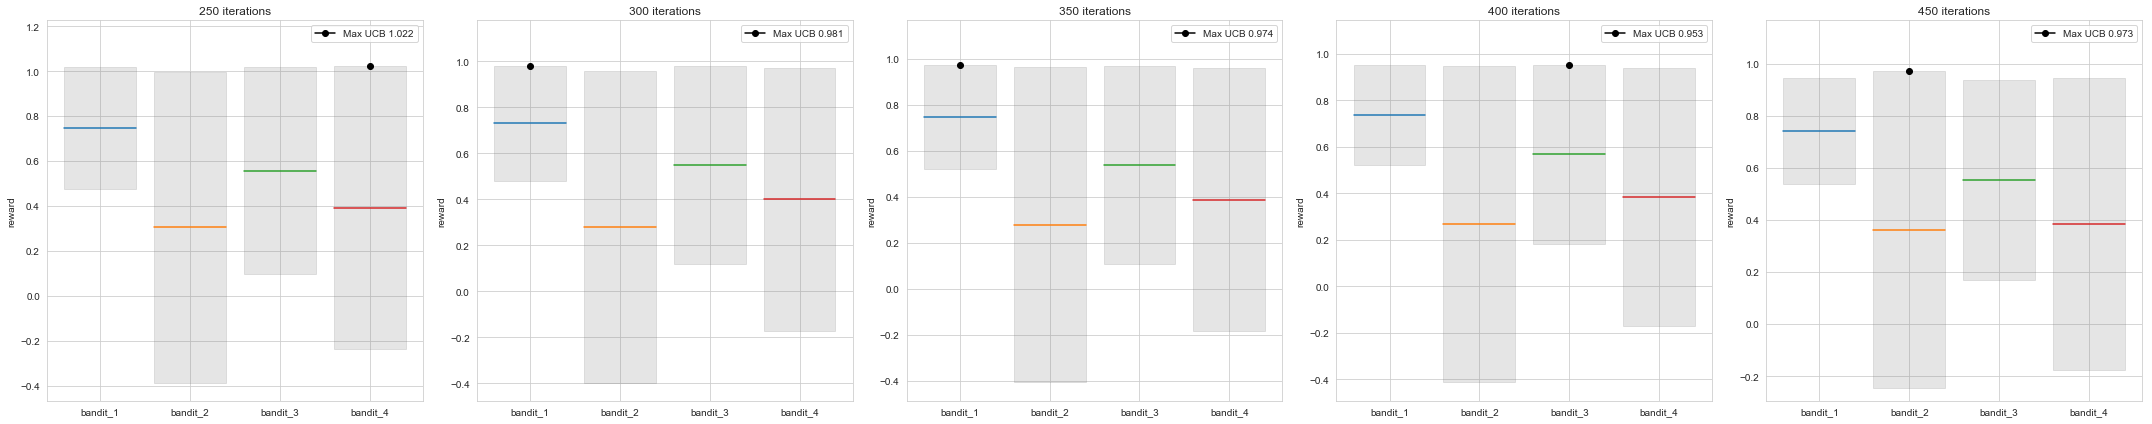

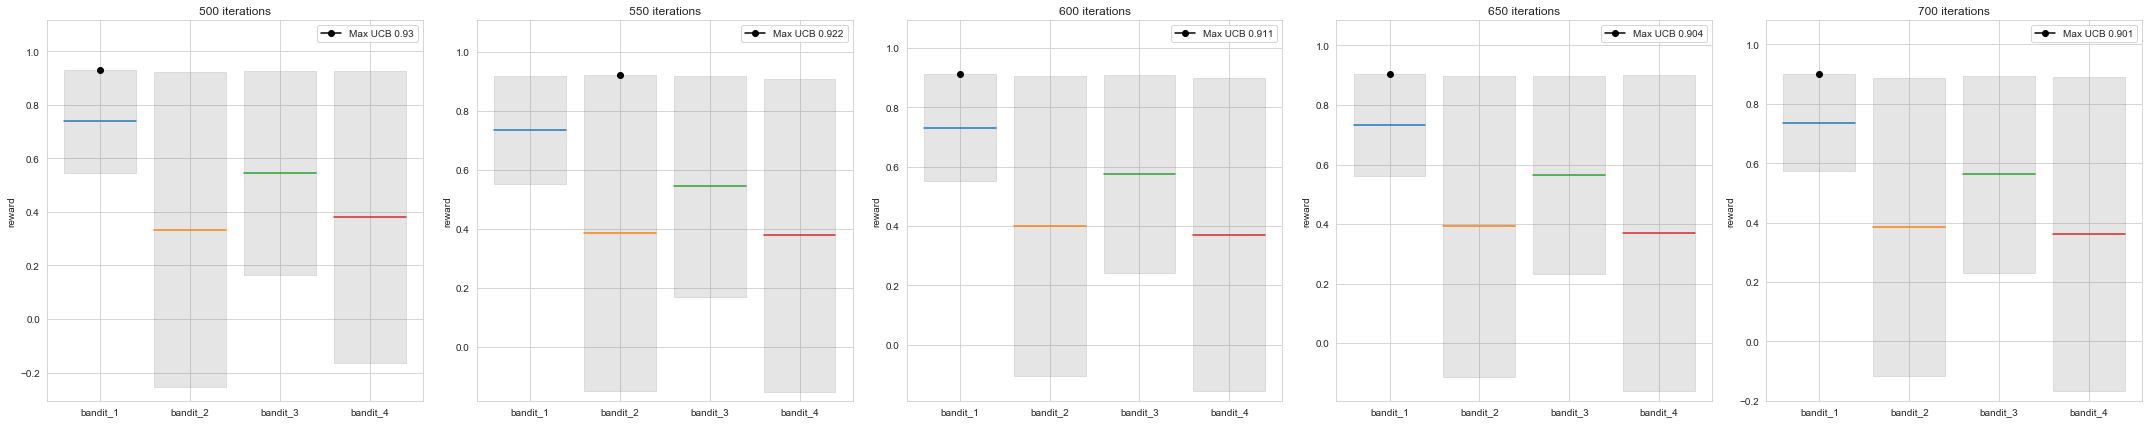

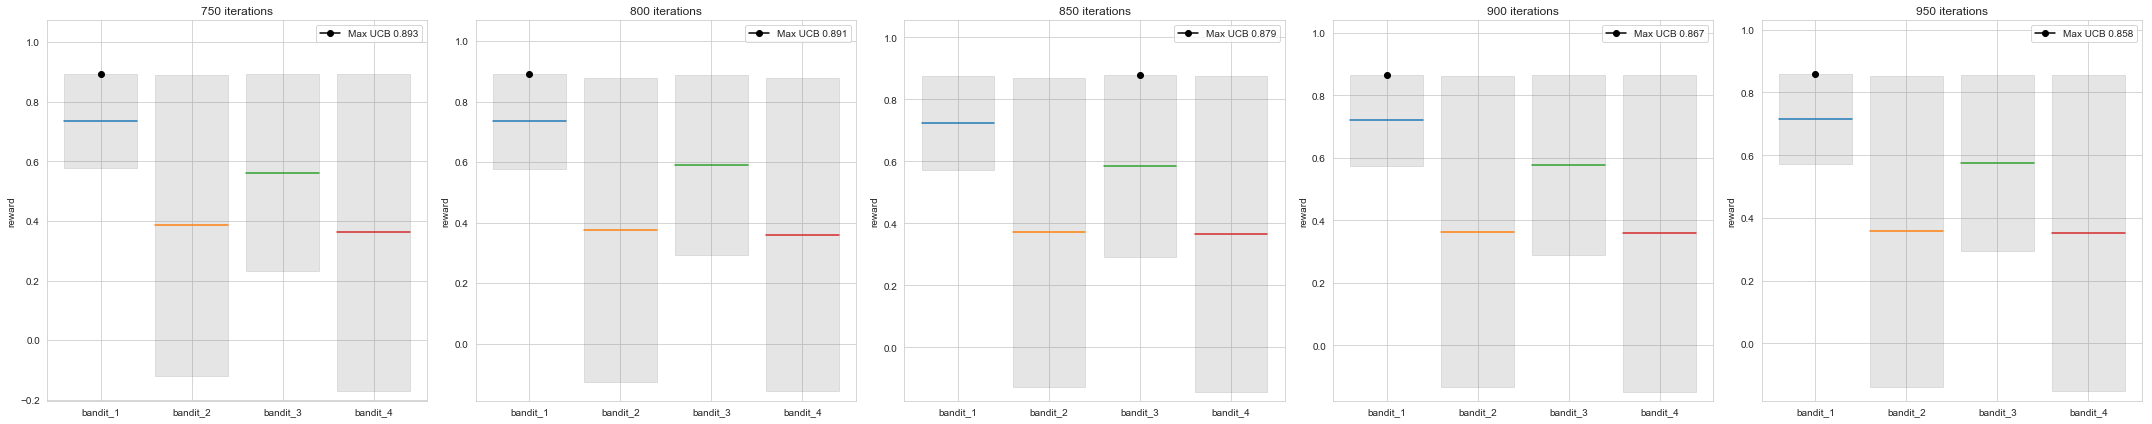

In [28]:
from utils.plot_utils import plot_ucb_evolution


sns.set_style("whitegrid")
plot_ucb_evolution(learner, interval=50,ncols=5)

## Thompson Sampling

Thompson sampling (**TS**) is one of the oldest heuristics for multi-armed bandit problems. It takes a Bayesian approach to find the optimal arm while balancing the trade off between exploration and exploitation of non-optimal arms.<br>

In this application of TS, the reward of each arm is distributed [Bernoulli](https://en.wikipedia.org/wiki/Bernoulli_distribution) and the expected reward is unknown. As usual, the objective is to find the optimal arm that gives maximum expected cumulative reward.<br>

The TS algorithm assumes a prior knowledge on where the reward of each arm should be located. Based on this prior knowledge, it starts to play arms and observe rewards (or failures): the information gathered from the observations are then used to update the prior knowlegde of each arm, via [Baye's Theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem).<br>
In a nutshell:

1. Suppose $\mu_i \sim f_i(\gamma_1,...,\gamma_k)$, where $\gamma_1,\gamma_2,...,\gamma_k$ are parameters defining the prior distribution on the reward of arm $i$
2. Sample a value of $\mu$ for each arm, play the arm with the highest sampled value
3. Observe a reward $r$
4. Compute the *posterior* reward distribution for the played arm using the observed reward
    \begin{equation}
        f_i(\gamma^*_1,...,\gamma^*_k)=f_i(\gamma_1,...,\gamma_k|r) \propto f_i(r|\gamma_1,...,\gamma_k)f_i(\gamma_1,...,\gamma_k)
    \end{equation}
5. Repeat from step 2 
    
How do we define a prior distribution on the rewards? As the expected reward value is distributed Bernoulli, a natural way of defining its prior is via the so-called [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) 

<img src="./images/beta.png" width="2000">

\begin{equation}
μ_i\sim \text{Beta}(\alpha_i, \beta_i),\quad i=1,2,...,n
\end{equation}

Here the parameters $\alpha_i$ and $\beta_i$ define the location of the expected value of $\mu_i$ and the uncertainty around it: they correspond to the number of successes ($\alpha_i$) and failures ($\beta_i$) we get over a bernoulli experiment made over $\alpha_i+\beta_i$ trials. For example

1. $\alpha_i = 1$ and $\beta_i = 1$; we expect the reward probability to be 50% but we are not very confident.
2. $\alpha_i = 1000$ and $\beta_ = 9000$; we strongly believe that the reward probability is 10%.

Now that we know what prior to associate to the reward, how do we compute the posterior distribution? Generally this step could require some sampling techniques, like [Markvo Chain MonteCarlo](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo), that allows us to numerically approximate the posterior. However, for a [specific family](https://en.wikipedia.org/wiki/Conjugate_prior) of distributions, we can compute the exact posterior analytically: the Beta distribution belongs to this family, and its Bayesian update is simply

1. observe reward $r$ for action $i$
2. if $r=1$, then $\text{Beta}(\alpha^*_i, \beta^*_i) = \text{Beta}(\alpha_i+1, \beta_i)$
3. else $\text{Beta}(\alpha^*_i, \beta^*_i) = \text{Beta}(\alpha_i, \beta_i+1)$


More generally, if we observe $S_i$ successes and $F_i$ failures in $T_i = S_i+F_i$ plays of arm $i$, the posterior distribution on such arm is simply

\begin{align}
\text{Beta}(\alpha^*_i, \beta^*_i) = \text{Beta}(\alpha_i+S_i, \beta_i+F_i)\\
\end{align}

Now that we have all the necessary details, we can look at the TS policy

<img src="./images/TS_policy.png" width="800">

The idea is simple: using our prior understanding of the expected reward distribution behind each action, let’s draw samples and pick the argmax as our selected action. That’s the Thompson sampling policy: both greedy and stochastic.

The result of this policy is profound: when our model is confident about a decision, it will consistently repeat that behavior. When it is less confident, it will explore other options with a higher likelihood.

In the following we will apply the TS policy to our toy dataset.

In [29]:
from mab.thompson.thompson_sampling import BernoulliTS

In [30]:
learner = BernoulliTS(toy_dataset.shape[1],toy_dataset.shape[0],np.array([1,1,1,1]),np.array([1,1,1,1]))

In [31]:
learner.run_experiment(0,toy_dataset.values)

In [32]:
learner.number_of_selections

array([937.,   9.,  39.,  15.])

We can now analyze the behavior of the algorithm.

### Has been the best option used most of the times?

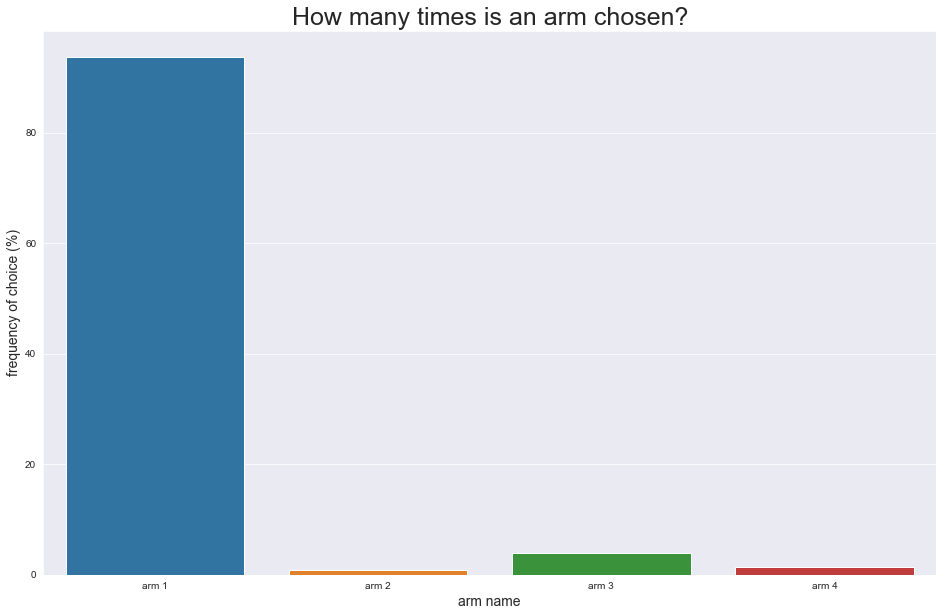

In [33]:
sns.set_style("darkgrid")

data = pd.DataFrame(data=np.array(learner.selected_arms),dtype=int,columns=['selected_arm'])
data['choice_probability']=1.
data=data.groupby('selected_arm')[['choice_probability']].count()
data=data*100/data.sum()
data['arm'] = ['arm 1','arm 2','arm 3','arm 4']

plt.figure(figsize=(16,10))
sns.barplot(x='arm', y='choice_probability',data=data)
plt.title('How many times is an arm chosen?',fontsize=25)
plt.ylabel('frequency of choice (%)',fontsize=14)
plt.xlabel('arm name',fontsize=14)
plt.show()

### What is the evolution of the estimated success rate of each arm?

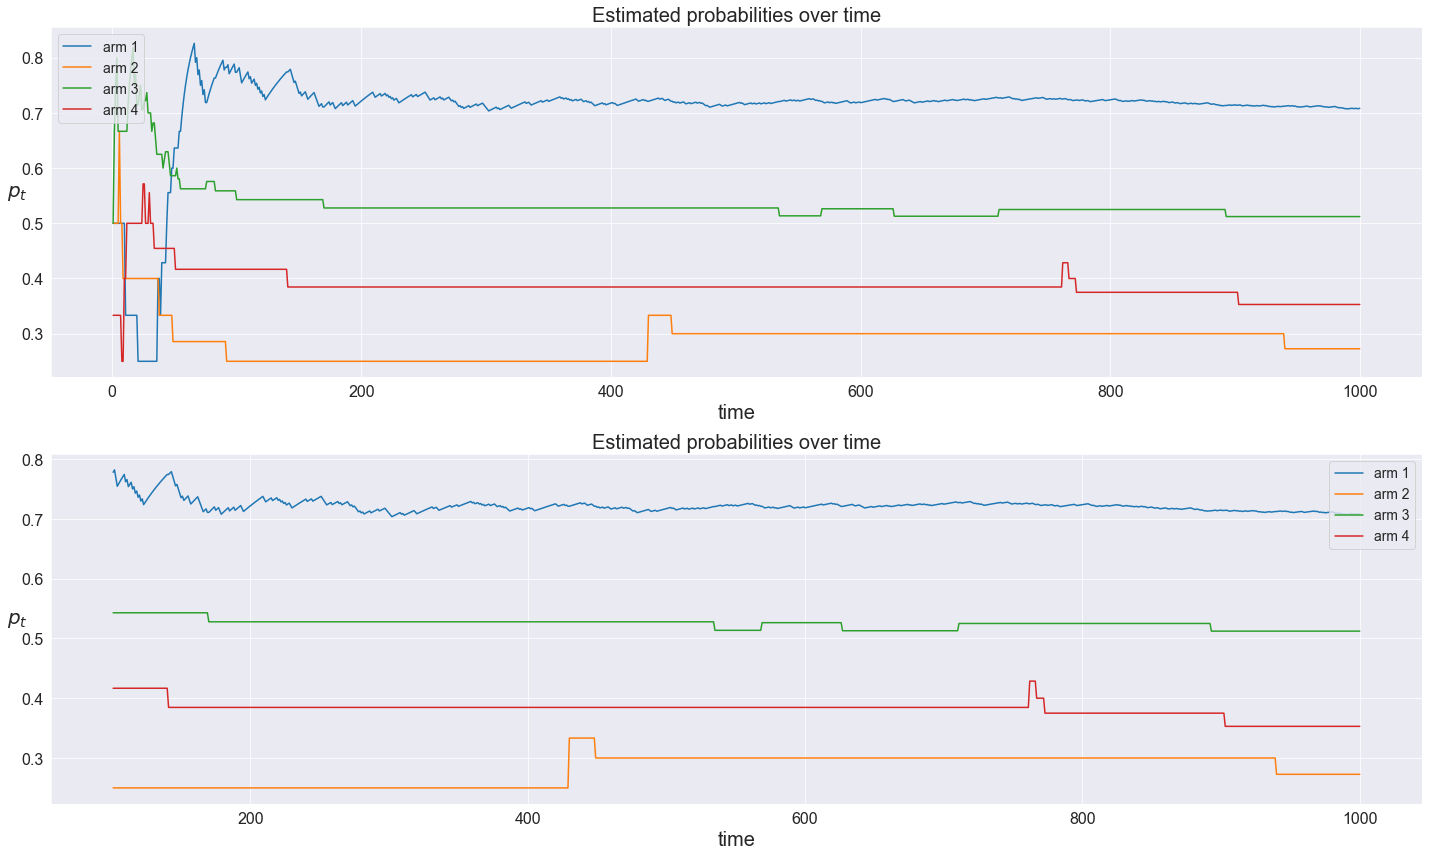

In [34]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(20,12))

xpoints = np.arange(1,learner.number_of_trials+1)

learner.arms_average_rewards = learner.step_alphas/(learner.step_alphas+learner.step_betas)

ax1.plot(xpoints,learner.arms_average_rewards[:,0],label='arm 1')
ax1.plot(xpoints,learner.arms_average_rewards[:,1],label='arm 2')
ax1.plot(xpoints,learner.arms_average_rewards[:,2],label='arm 3')
ax1.plot(xpoints,learner.arms_average_rewards[:,3],label='arm 4')
ax1.set_xlabel('time',fontsize=20)
ax1.set_ylabel('$p_t$',fontsize=20,rotation='horizontal')
ax1.set_title('Estimated probabilities over time',fontsize=20)
ax1.legend(prop={'size': 14})
ax1.tick_params(axis='both', which='major', labelsize=16)

ax2.plot(xpoints[100:],learner.arms_average_rewards[100:,0],label='arm 1')
ax2.plot(xpoints[100:],learner.arms_average_rewards[100:,1],label='arm 2')
ax2.plot(xpoints[100:],learner.arms_average_rewards[100:,2],label='arm 3')
ax2.plot(xpoints[100:],learner.arms_average_rewards[100:,3],label='arm 4')
ax2.set_xlabel('time',fontsize=20)
ax2.set_ylabel('$p_t$',fontsize=20,rotation='horizontal')
ax2.set_title('Estimated probabilities over time',fontsize=20)
ax2.legend(prop={'size': 14})
ax2.tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()
plt.show()

In [35]:
total_reward = learner.compute_step_cumulative_reward(toy_dataset.values)

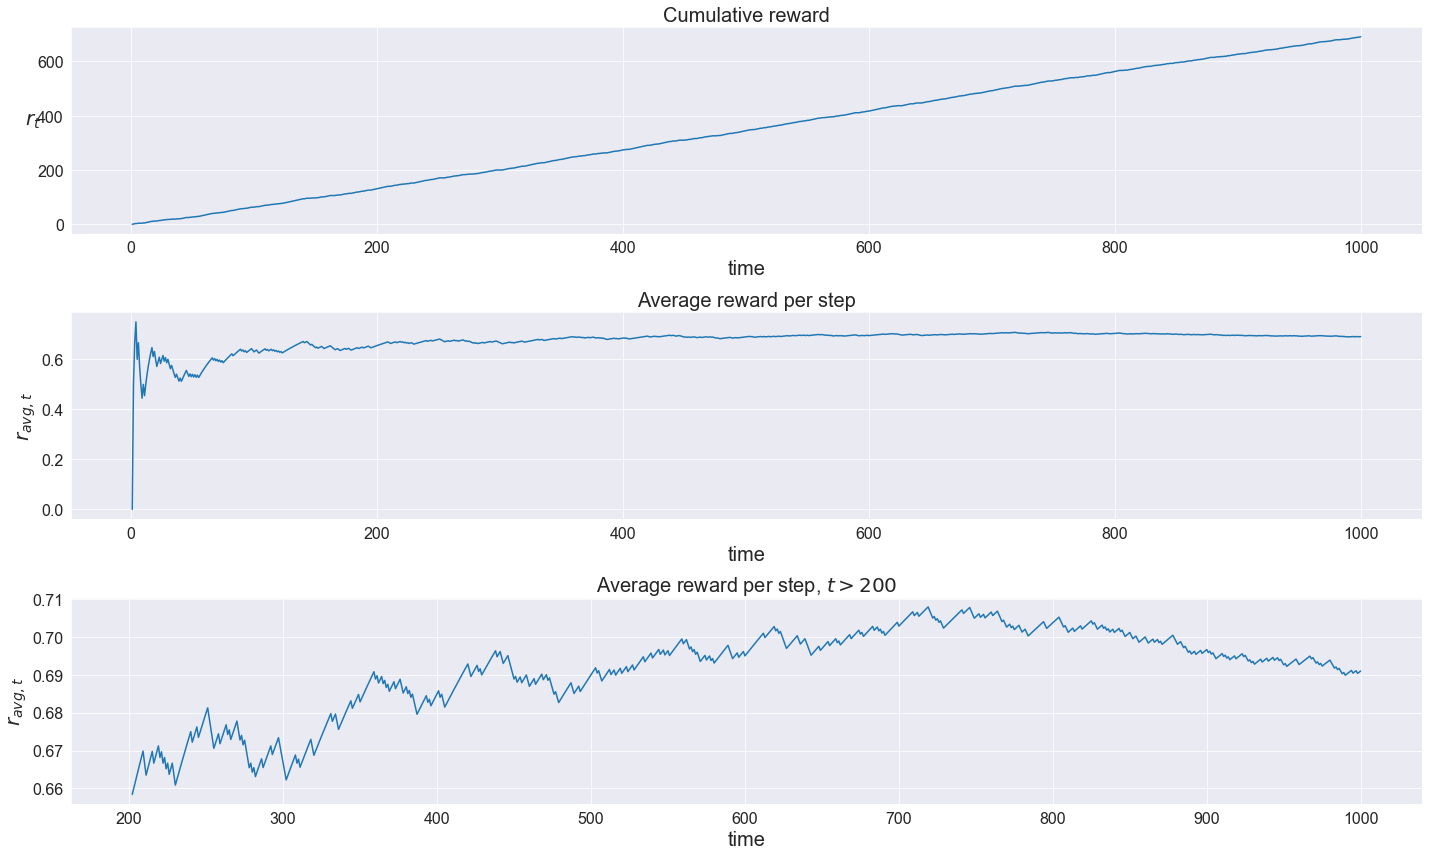

In [36]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(20,12))

xpoints = np.arange(1,learner.number_of_trials+1)
ax1.plot(xpoints,total_reward)
ax1.set_xlabel('time',fontsize=20)
ax1.set_ylabel('$r_t$',fontsize=20,rotation='horizontal')
ax1.set_title('Cumulative reward',fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=16)

ax2.plot(xpoints,total_reward/xpoints)
ax2.set_xlabel('time',fontsize=20)
ax2.set_ylabel('$r_{avg,t}$',fontsize=20)
ax2.set_title('Average reward per step',fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=16)

ax3.plot(xpoints[201:],total_reward[201:]/xpoints[201:])
ax3.set_xlabel('time',fontsize=20)
ax3.set_ylabel('$r_{avg,t}$',fontsize=20)
ax3.set_title('Average reward per step, $t > 200$',fontsize=20)
ax3.tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()
plt.show()

Let us now plot the evolution of the posterior distributions of each arm

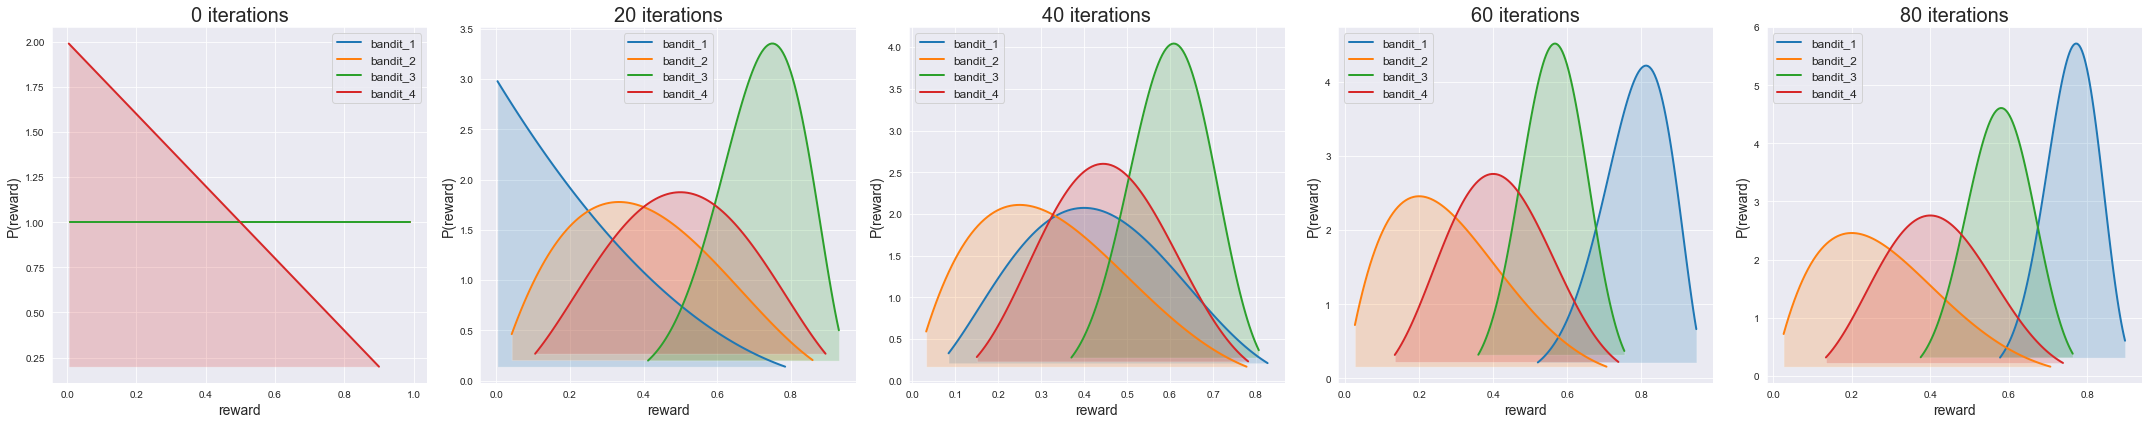

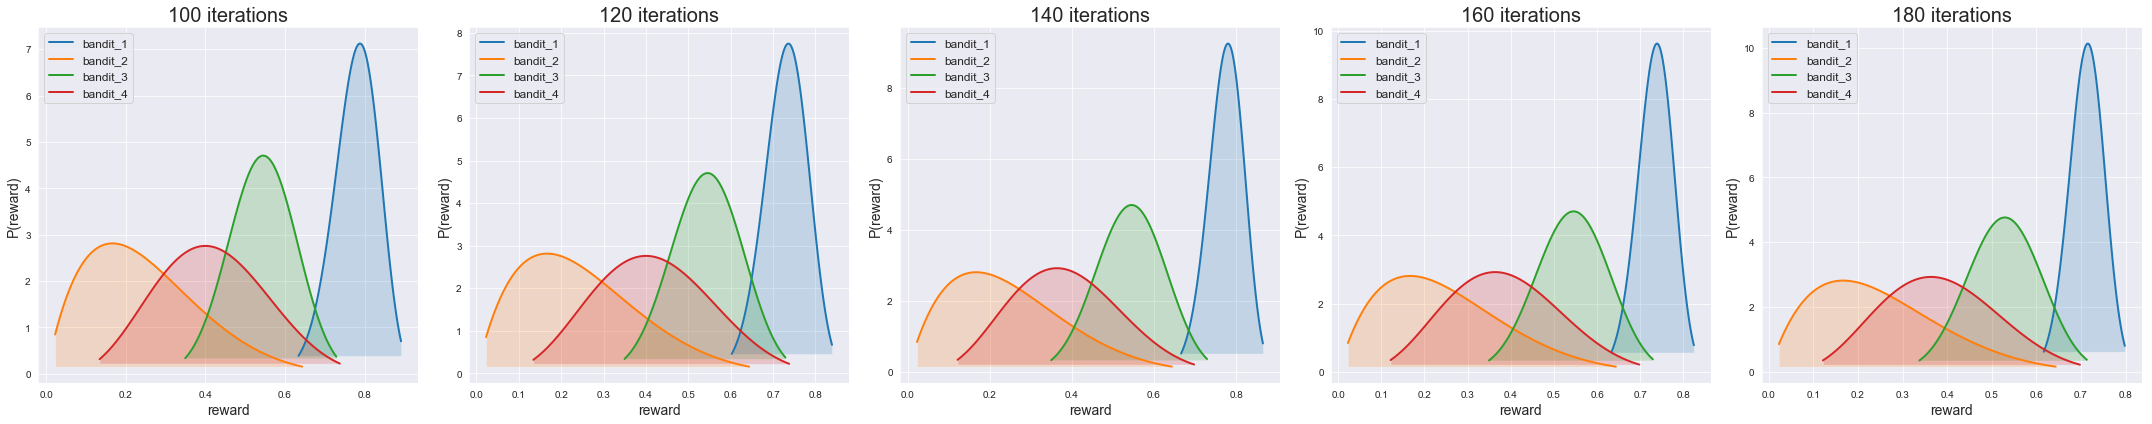

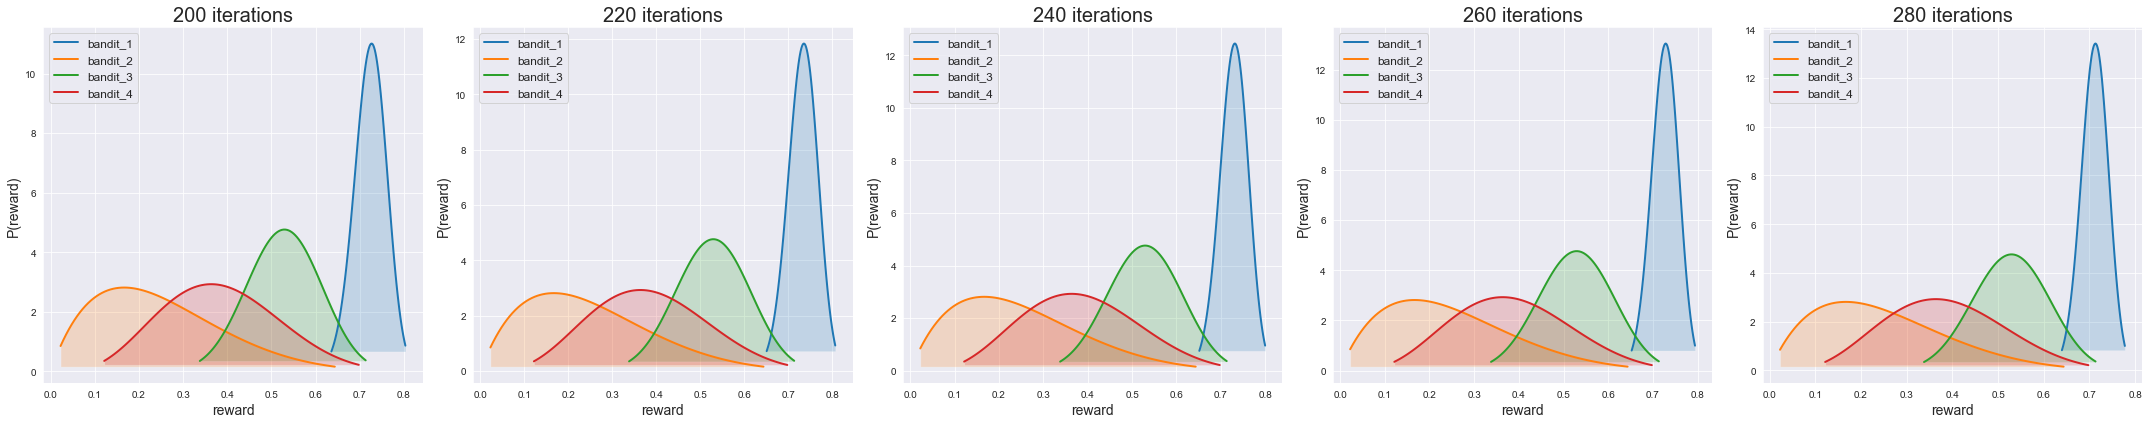

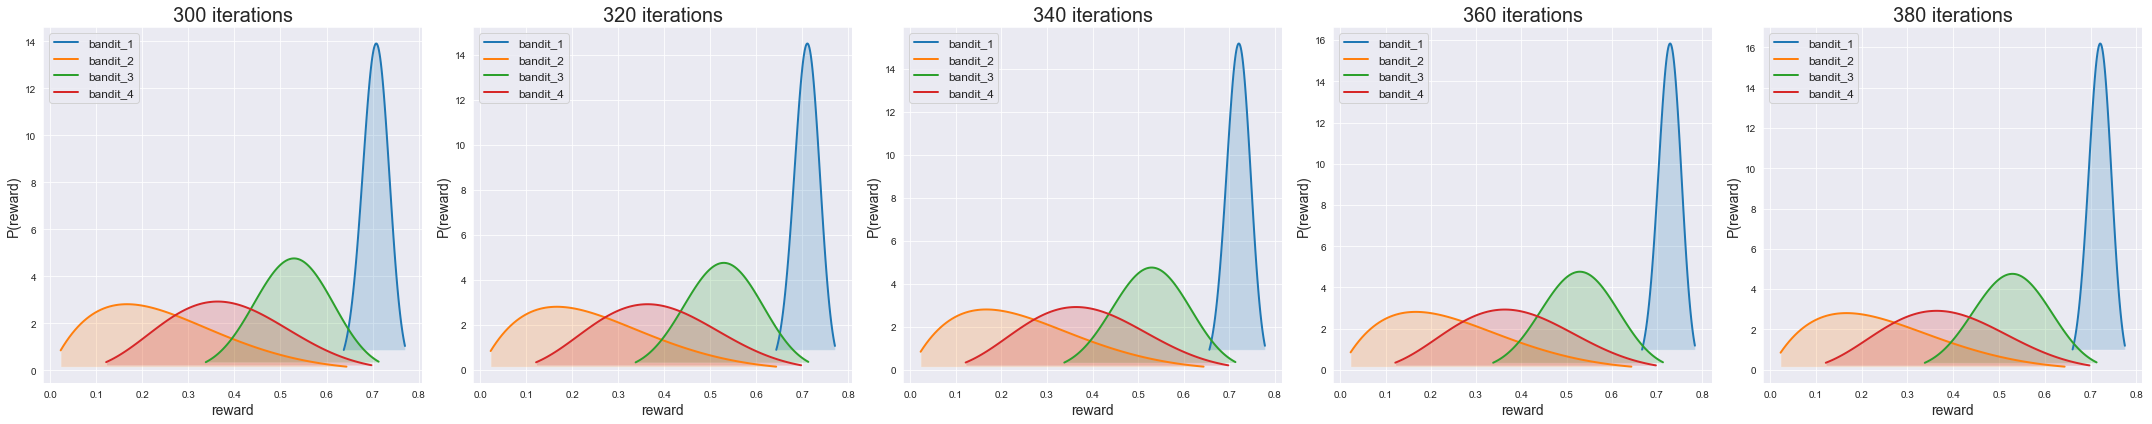

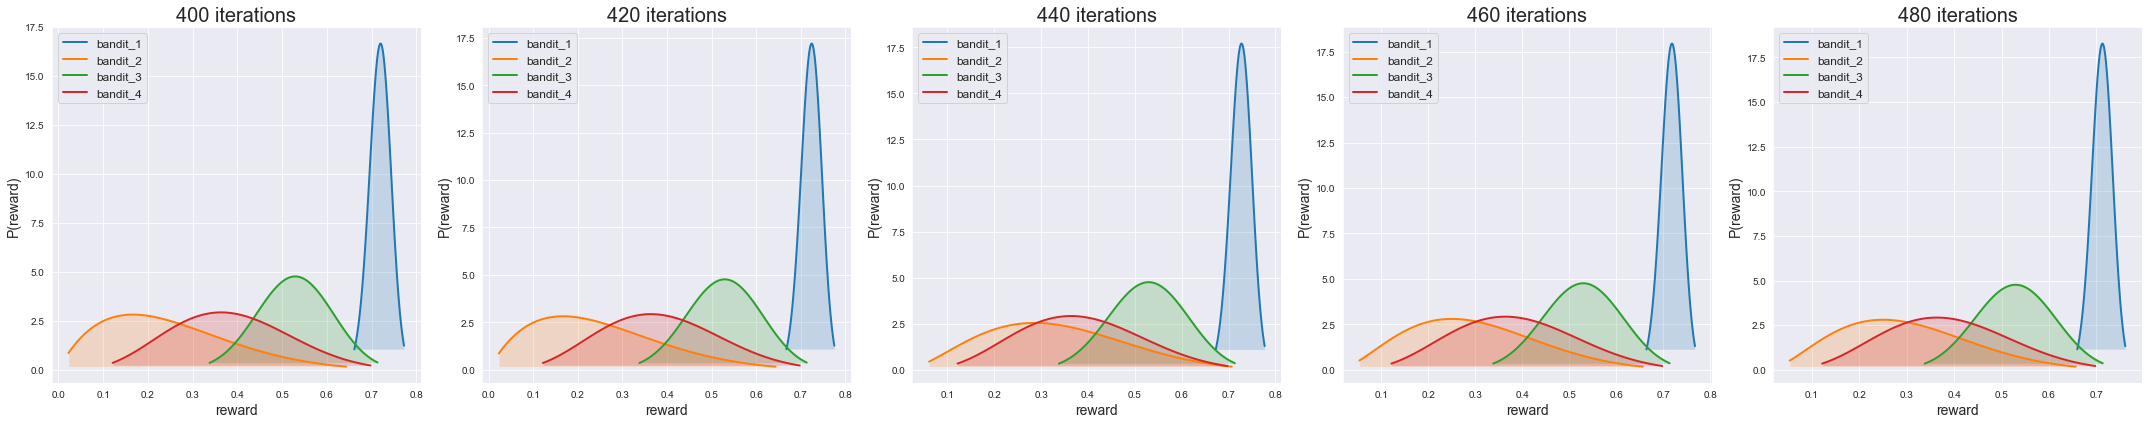

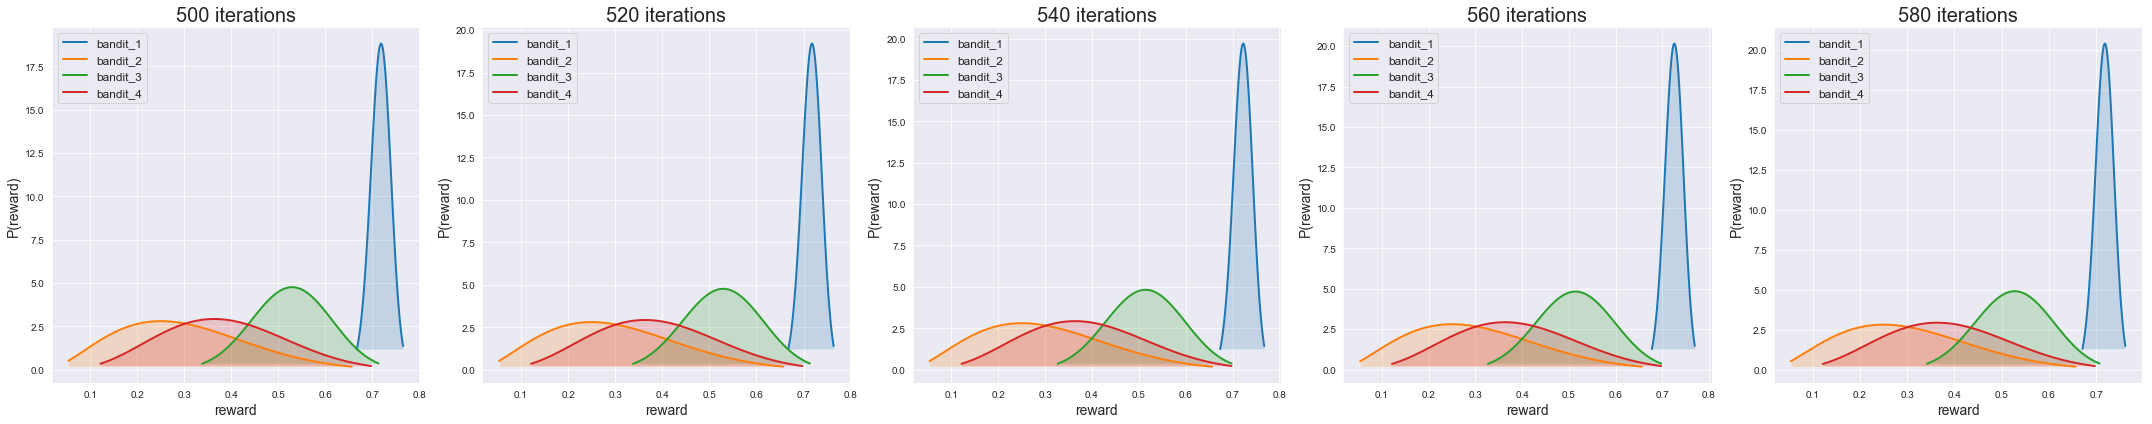

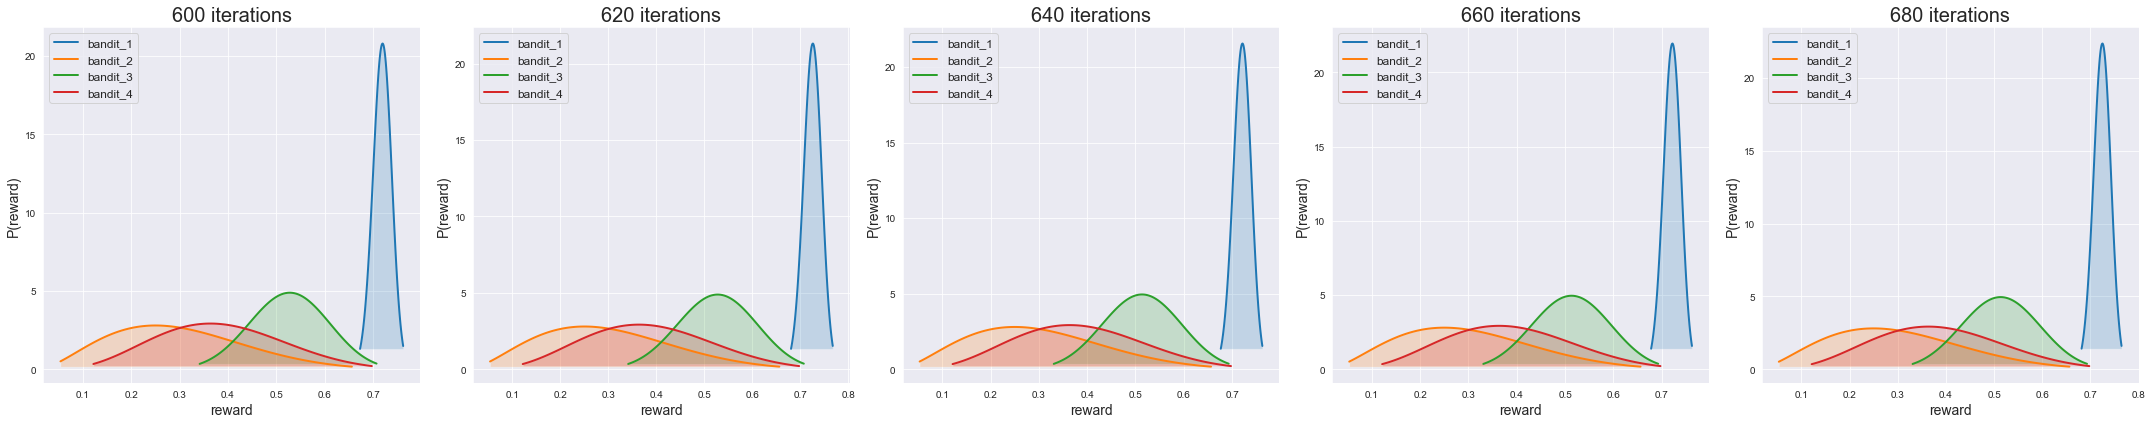

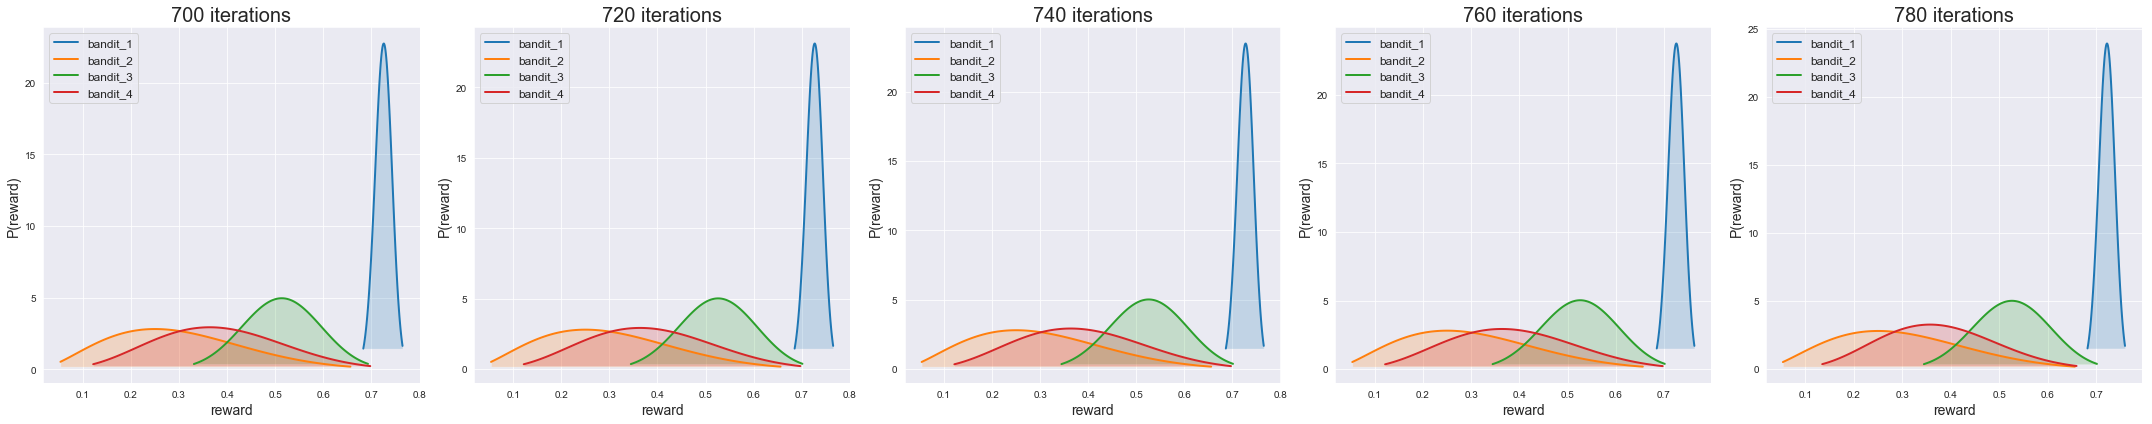

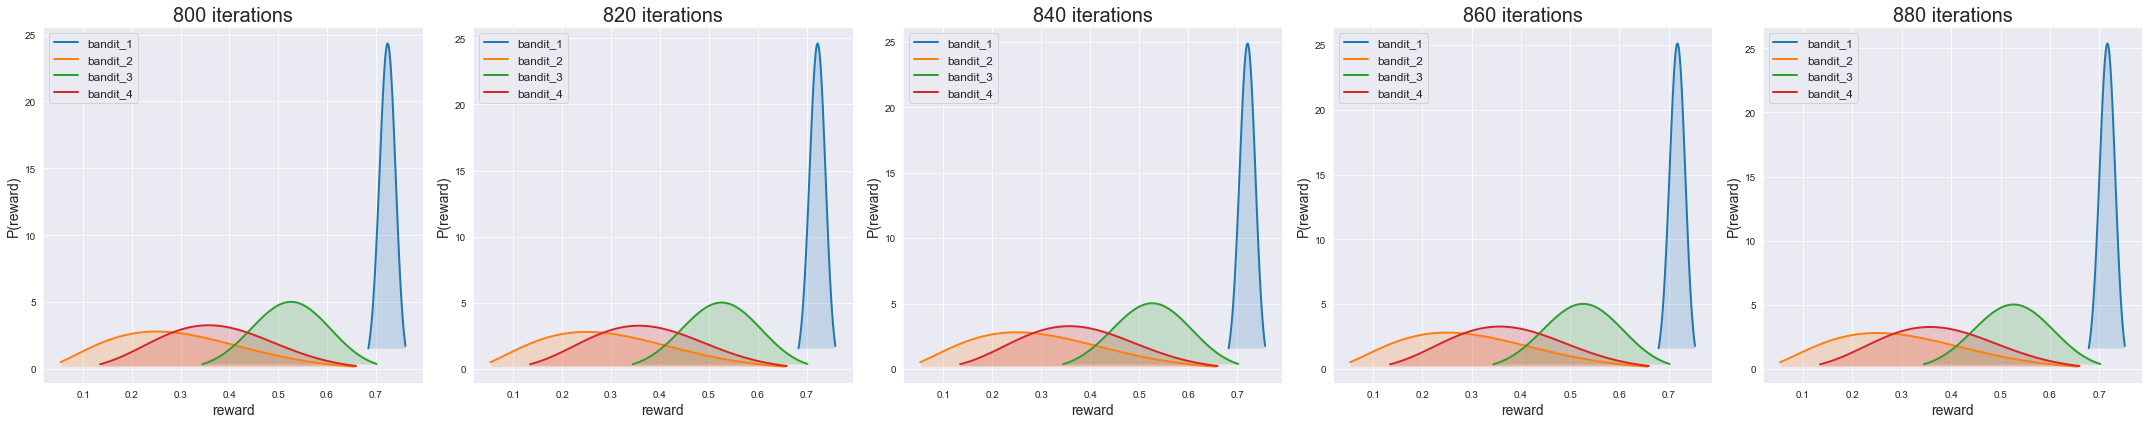

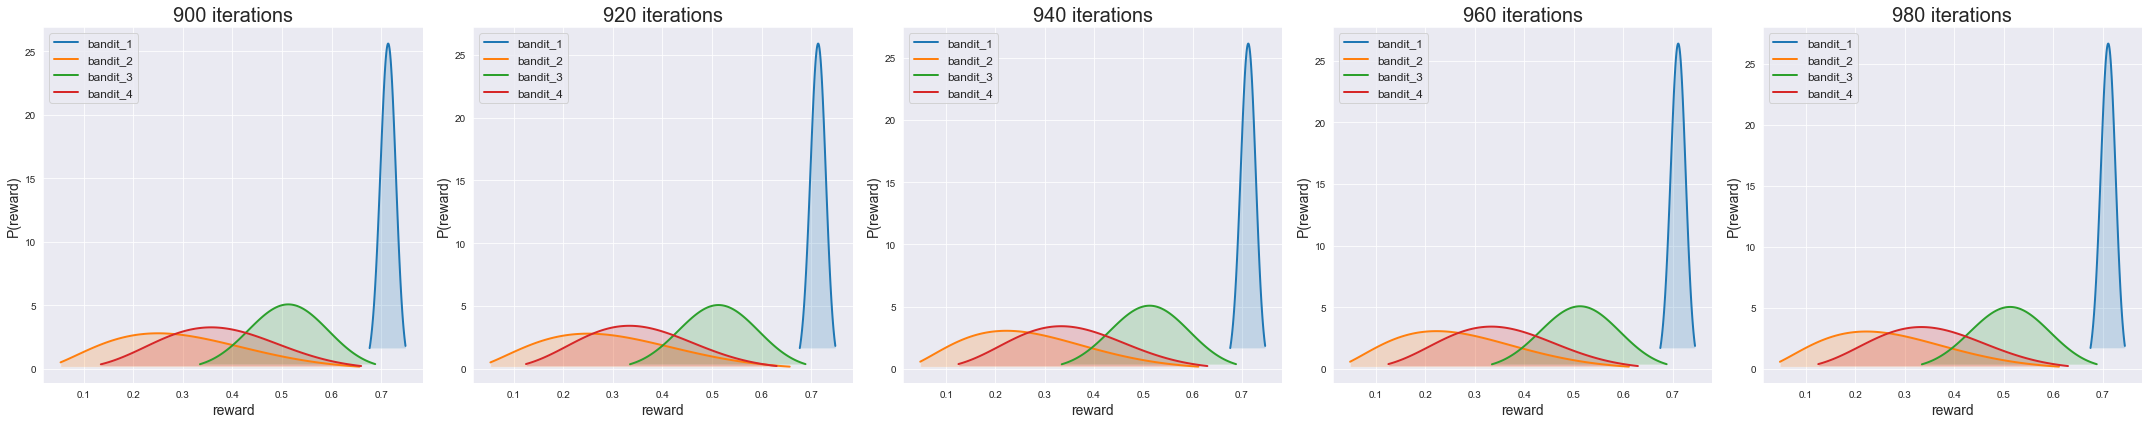

In [37]:
from utils.plot_utils import plot_ts_evolution
plot_ts_evolution(learner)

As we can see, in the beginning the algorithm has no knowledge about the location of each arm reward, neither about the spread around it. This is due to the fact we have used a flat prior to describe the initial distributions.
As a consequence, TS will initially perform a lot of exploration to understand where each reward is located and how much confident it is about their location. Once it has identified the best arm with enough confidence, it will start to play it more and more frequently.
The bayesian update coupled with the stochastic sampling allow the TS to perform a smooth transition from the full exploration to the full exploitation phase.

## Regret analysis

To compare the scaling properties of each algorithm we perform a certain number of experiments and estimate their regret.

In [38]:
from utils.analysis import regret_analysis

In [59]:
rewards = np.array([.77,.3,.55,.4])
n_experiments = 100
number_of_trials = 1000

In [60]:
egreddy_reg_avg,egreddy_reg_std,egreddy_rew_avg,egreddy_rew_std = regret_analysis(n_experiments,number_of_trials,rewards,BernoulliEGreedy,epsilon=0.3, init_probas=np.array([.5,.5,.5,.5]))

[=================== ] 99%

In [65]:
boltzmann_reg_avg,boltzmann_reg_std,boltzmann_rew_avg,boltzmann_rew_std = regret_analysis(n_experiments,number_of_trials,rewards,BernoulliSoftmaxAnnealing,kappa=0.1, init_probas=np.array([.5,.5,.5,.5]))

[=================== ] 99%

In [62]:
ucb_reg_avg,ucb_reg_std,ucb_rew_avg,ucb_rew_std= regret_analysis(n_experiments,number_of_trials,rewards,BernoulliUCB)

[=================== ] 99%

In [63]:
ts_reg_avg,ts_reg_std,ts_rew_avg,ts_rew_std = regret_analysis(n_experiments,number_of_trials,rewards,BernoulliTS,prior_alphas=np.array([1,1,1,1]), prior_betas=np.array([1,1,1,1]))

[=================== ] 99%

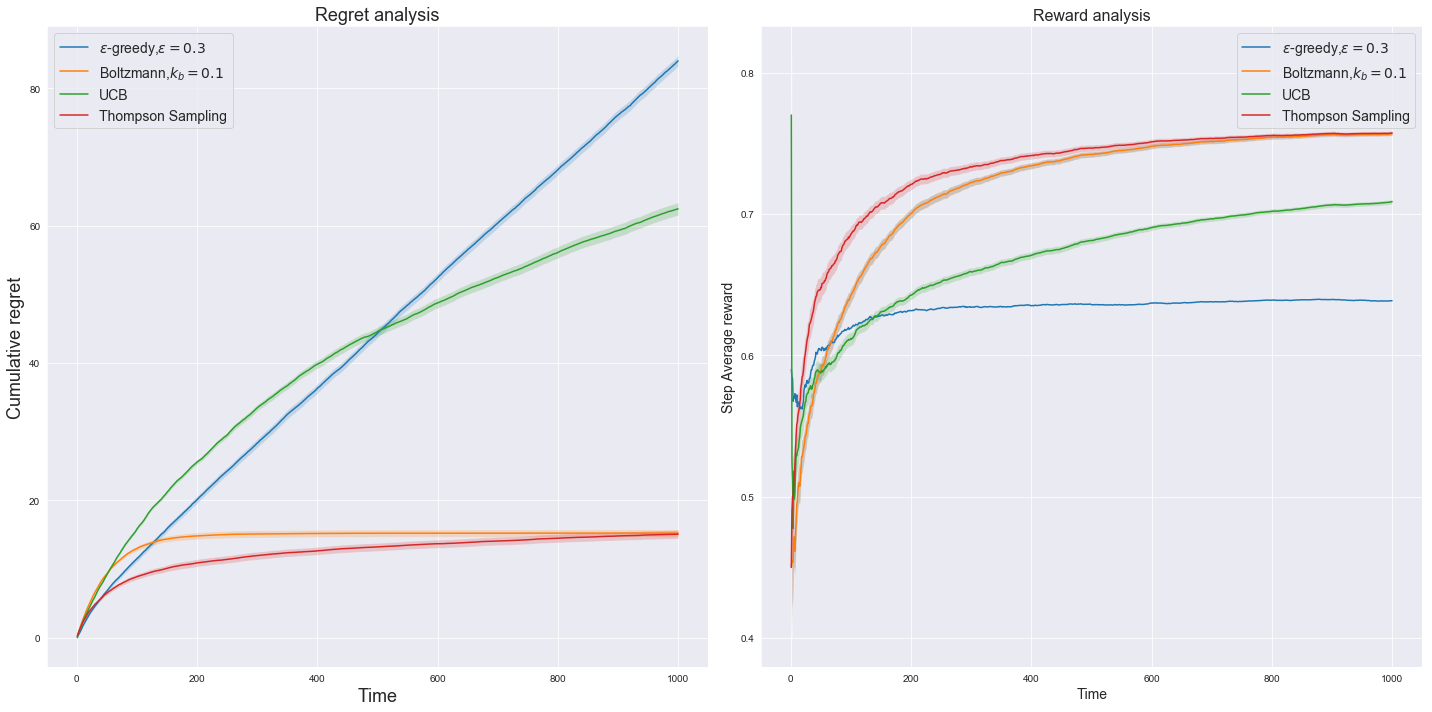

In [66]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))

xpoints = range(1,number_of_trials+1)
ax1.plot(xpoints,egreddy_reg_avg,label='$\epsilon$-greedy,$\epsilon=0.3$')
ax1.fill_between(xpoints,egreddy_reg_avg+egreddy_reg_std,egreddy_reg_avg-egreddy_reg_std,alpha=0.2)
ax1.plot(xpoints,boltzmann_reg_avg,label='Boltzmann,$k_b=0.1$')
ax1.fill_between(xpoints,boltzmann_reg_avg+boltzmann_reg_std,boltzmann_reg_avg-boltzmann_reg_std,alpha=0.2)
ax1.plot(xpoints,ucb_reg_avg,label='UCB')
ax1.fill_between(xpoints,ucb_reg_avg+ucb_reg_std,ucb_reg_avg-ucb_reg_std,alpha=0.2)
ax1.plot(xpoints,ts_reg_avg,label='Thompson Sampling')
ax1.fill_between(xpoints,ts_reg_avg+ts_reg_std,ts_reg_avg-ts_reg_std,alpha=0.2)
ax1.set_ylabel('Cumulative regret',fontsize=18)
ax1.set_xlabel('Time',fontsize=18)
ax1.set_title('Regret analysis',fontsize=18)
ax1.legend(prop={'size': 14})

ax2.plot(xpoints,egreddy_rew_avg/xpoints,label='$\epsilon$-greedy,$\epsilon=0.3$')
ax2.fill_between(xpoints,(boltzmann_rew_avg+boltzmann_rew_std)/xpoints,(boltzmann_rew_avg-boltzmann_rew_std)/xpoints,alpha=0.2)
ax2.plot(xpoints,boltzmann_rew_avg/xpoints,label='Boltzmann,$k_b=0.1$')
ax2.fill_between(xpoints,(boltzmann_rew_avg+boltzmann_rew_std)/xpoints,(boltzmann_rew_avg-boltzmann_rew_std)/xpoints,alpha=0.2)
ax2.plot(xpoints,ucb_rew_avg/xpoints,label='UCB')
ax2.fill_between(xpoints,(ucb_rew_avg+ucb_rew_std)/xpoints,(ucb_rew_avg-ucb_rew_std)/xpoints,alpha=0.2)
ax2.plot(xpoints,ts_rew_avg/xpoints,label='Thompson Sampling')
ax2.fill_between(xpoints,(ts_rew_avg+ts_rew_std)/xpoints,(ts_rew_avg-ts_rew_std)/xpoints,alpha=0.2)
ax2.set_ylabel('Step Average reward',fontsize=14)
ax2.set_xlabel('Time',fontsize=14)
ax2.set_title('Reward analysis',fontsize=16)
ax2.legend(prop={'size': 14})

plt.tight_layout()
plt.show()

As we can see, on the long term the $\epsilon$-greedy strategy is not the best one as its regret scales linearly with time.
On the other hand UCB and Thompson sampling are better policiesd as they have a logarithmically scaling regret.
Also the Boltzmann exploration performs quite well: the only main issue with this procedure is that we have to carefully choose the value of the hyperparameter $k_b$. Wrong values of $k_b$ have a negative impact on the algorithm convergence, see the example below

In [67]:
boltzmann_reg_avg_1,boltzmann_reg_std_1,boltzmann_rew_avg_1,boltzmann_rew_std_1 = regret_analysis(n_experiments,number_of_trials,rewards,BernoulliSoftmaxAnnealing,kappa=0.001, init_probas=np.array([.5,.5,.5,.5]))

[=================== ] 99%

In [68]:
boltzmann_reg_avg_2,boltzmann_reg_std_2,boltzmann_rew_avg_2,boltzmann_rew_std_2 = regret_analysis(n_experiments,number_of_trials,rewards,BernoulliSoftmaxAnnealing,kappa=0.1, init_probas=np.array([.5,.5,.5,.5]))

[=================== ] 99%

In [78]:
boltzmann_reg_avg_3,boltzmann_reg_std_3,boltzmann_rew_avg_3,boltzmann_rew_std_3 = regret_analysis(n_experiments,number_of_trials,rewards,BernoulliSoftmaxAnnealing,kappa=.8, init_probas=np.array([.5,.5,.5,.5]))

[=================== ] 99%

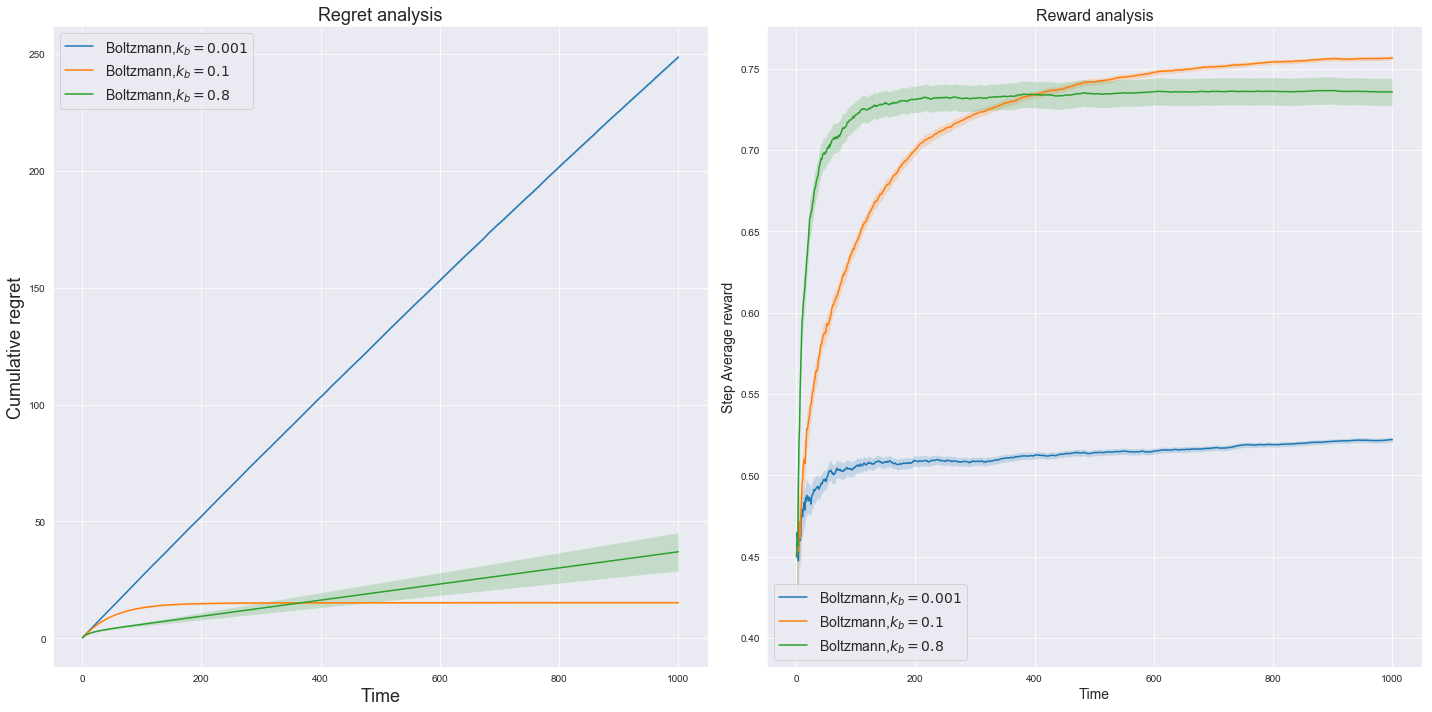

In [83]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))

xpoints = range(1,number_of_trials+1)
ax1.plot(xpoints,boltzmann_reg_avg_1,label='Boltzmann,$k_b=0.001$')
ax1.fill_between(xpoints,boltzmann_reg_avg_1+boltzmann_reg_std_1,boltzmann_reg_avg_1-boltzmann_reg_std_1,alpha=0.2)
ax1.plot(xpoints,boltzmann_reg_avg_2,label='Boltzmann,$k_b=0.1$')
ax1.fill_between(xpoints,boltzmann_reg_avg_2+boltzmann_reg_std_2,boltzmann_reg_avg_2-boltzmann_reg_std_2,alpha=0.2)
ax1.plot(xpoints,boltzmann_reg_avg_3,label='Boltzmann,$k_b=0.8$')
ax1.fill_between(xpoints,boltzmann_reg_avg_3+boltzmann_reg_std_3,boltzmann_reg_avg_3-boltzmann_reg_std_3,alpha=0.2)
ax1.set_ylabel('Cumulative regret',fontsize=18)
ax1.set_xlabel('Time',fontsize=18)
ax1.set_title('Regret analysis',fontsize=18)
ax1.legend(prop={'size': 14})

ax2.plot(xpoints,boltzmann_rew_avg_1/xpoints,label='Boltzmann,$k_b=0.001$')
ax2.fill_between(xpoints,(boltzmann_rew_avg_1+boltzmann_rew_std_1)/xpoints,(boltzmann_rew_avg_1-boltzmann_rew_std_1)/xpoints,alpha=0.2)
ax2.plot(xpoints,boltzmann_rew_avg_2/xpoints,label='Boltzmann,$k_b=0.1$')
ax2.fill_between(xpoints,(boltzmann_rew_avg_2+boltzmann_rew_std_2)/xpoints,(boltzmann_rew_avg_2-boltzmann_rew_std_2)/xpoints,alpha=0.2)
ax2.plot(xpoints,boltzmann_rew_avg_3/xpoints,label='Boltzmann,$k_b=0.8$')
ax2.fill_between(xpoints,(boltzmann_rew_avg_3+boltzmann_rew_std_3)/xpoints,(boltzmann_rew_avg_3-boltzmann_rew_std_3)/xpoints,alpha=0.2)
ax2.set_ylabel('Step Average reward',fontsize=14)
ax2.set_xlabel('Time',fontsize=14)
ax2.set_title('Reward analysis',fontsize=16)
ax2.legend(prop={'size': 14})

plt.tight_layout()
plt.show()